# Machine Learning Assignment: Multivariate Regression on Track running data

# nog te doen:

### Outlier detectie
### Per functie doel er in zetten
### verzamelen wat je aan kolomen verwijderd en motiveren -> kopieren naar verslag


## Notebook setup

### Libraries

In [32]:
#pip install --upgrade scikit-learn

In [33]:
# libraries
import os
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample  # Import resample

### Data import

In [65]:
# Import csv-file with summary of garmin activities

summary_csv_path = os.path.join('C:/Users/michel.marien_icarew/Documents/GitHub/Machine-learning/docs/', 'Garmin_activity_description.csv')

def import_csv(csv_path):    

    with open(csv_path, 'r') as csv_file:
        garmin_activities_csv = pd.read_csv(csv_file,
                                        sep=';',
                                        encoding='utf-8')
        
    return garmin_activities_csv

garmin_act_summary = import_csv(summary_csv_path)
garmin_act_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Activiteittype              226 non-null    object 
 1   Datum                       226 non-null    object 
 2   Favoriet                    226 non-null    bool   
 3   Titel                       226 non-null    object 
 4   Afstand                     226 non-null    float64
 5   CalorieÃ«n                  226 non-null    object 
 6   Tijd                        226 non-null    object 
 7   Gem. HS                     226 non-null    object 
 8   Max. HS                     226 non-null    object 
 9   Training effect aeroob      226 non-null    object 
 10  Gem. loopcadans             226 non-null    object 
 11  Max. loopcadans             226 non-null    object 
 12  Gemiddeld tempo             226 non-null    object 
 13  Beste tempo                 226 non

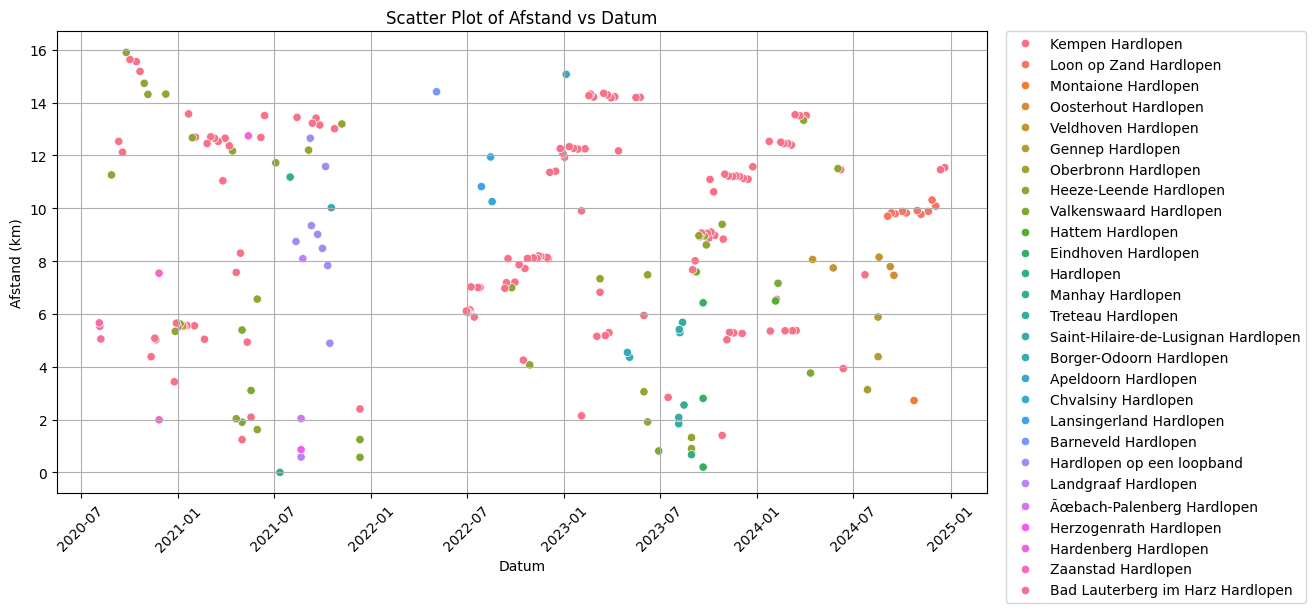

In [35]:
def plot_scatter(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=pd.to_datetime(df['Datum'], format='%d-%m-%Y %H:%M'), y='Afstand', hue='Titel', data=df)

    plt.grid(True)
    plt.xlabel('Datum')
    plt.ylabel('Afstand (km)')
    plt.title('Scatter Plot of Afstand vs Datum')
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0) 
    plt.xticks(rotation=45)
    plt.show()

plot_scatter(garmin_act_summary)

In [64]:
# Import csv-file with additional features

add_features_path = os.path.join('C:/Users/michel.marien_icarew/Documents/GitHub/Machine-learning/docs/', 'Additional_features.csv')

garmin_act_addfeatures = import_csv(add_features_path)

#garmin_act_addfeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ï»¿datum         216 non-null    object 
 1   plaats           216 non-null    object 
 2   afstand          216 non-null    float64
 3   addfeat_asphalt  216 non-null    float64
 4   addfeat_forest   216 non-null    float64
 5   addfeat_dunes    216 non-null    float64
 6   addfeat_temp     216 non-null    float64
 7   addfeat_sky      216 non-null    object 
 8   addfeat_windsp   216 non-null    int64  
 9   addfeat_winddir  216 non-null    object 
 10  addfeat_humid    216 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 18.7+ KB


## Data preprocessing

### Data preprocessing garmin summary-file

In [37]:
# Clean csv-file with summary of garmin activities

# Create groupings of track distances
def categorize_distance(distance):
    ''' Create tracks bins based on distance '''

    if distance < 8:                # tracks shorter than 8 km
        return '8'
    elif distance < 12:             # tracks shorter than 12 km
        return '12'
    elif distance < 20:             # tracks shorter than 20 km
        return '20'
    else:
        return '100'               # failsafe group

# Reduce titel column to location only and drop rows with no location
def remove_act_from_titel(df):
    ''' remove activity from titel-column and drop rows without titel'''

    df.loc[:, 'Titel'] = df['Titel'].str.replace('hardlopen', '', case=False).str.strip()

    df.loc[:, 'Titel'] = df['Titel'].str.replace('  ', ' ')

    df = df[df['Titel'].notna() & (df['Titel'] != '')].reset_index(drop=True)

    return df

# Drop dependent and uninformative columns
def drop_cols(df, cols_to_drop):
    ''' general function for dropping cols '''

    df = df.drop(cols_to_drop,axis=1)

    return df

# Convert duration and tempo to seconds
def convert_duration(df):
    ''' convert duration and tempo to seconds '''

    df['Gemiddeld tempo'] = pd.to_timedelta('00:' + df['Gemiddeld tempo'])

    df['Gemiddeld tempo'] = df['Gemiddeld tempo'].dt.total_seconds()

    df['Verstreken tijd'] = pd.to_timedelta(df['Verstreken tijd']).dt.total_seconds()

    return df


# Convert columns to numeric

def convert_numeric(df, num_cols):
    '''Convert columns to numeric and round to 2 decimals '''

    for col in num_cols:
        df[col] = df[col].apply(lambda x: round(float(str(x).replace(',', '.').strip()), 2))

    return df

def convert_date(df, date_cols):
    ''' convert date column to date''' 

    df['Datum'] = pd.to_datetime(df['Datum'], format='%d-%m-%Y %H:%M')

    return df

def convert_colheaders(df):
    ''' convert colheaders to lowercase and remove punctuation''' 

    df.columns = (
        df.columns
        .str.lower()
        .str.translate(str.maketrans('', '', string.punctuation))
        .str.replace(' ', '_'))

    return df

### Preprocess garmin summary file
date_cols = ['Datum']

num_cols = ['Totale stijging']

drop_columns = ['Activiteittype', 'Favoriet', 'CalorieÃ«n','Decompressie','Training Stress ScoreÂ®', 'Gem. vermogen', 'Gem. HS', 'Max. HS',
             'Max. vermogen','Beste rondetijd', 'Aantal ronden','Minimum hoogte', 'Maximum hoogte','Normalized PowerÂ® (NPÂ®)',
             'Gem. staplengte','Gemiddelde verticale ratio', 'Gem. verticale oscillatie' ,'Training effect aeroob','Beste tempo', 
             'Tijd bewogen', 'Gem. grondcontacttijd', 'Tijd','Gem. GAP','Gem. loopcadans','Max. loopcadans', 'Totale daling']


# Preprocess garmin summary file
def prep_garmin_summary(df,cols_to_drop,num_cols, date_cols):
    ''' apply preprocessing functions to imported garmin activities file'''

    df['track_lengths'] = df['Afstand'].apply(categorize_distance)

    df['Afstand'] = df['Afstand'].round(2)

    df = df.loc[df['Activiteittype'] == 'Hardlopen']  

    df.replace("--", np.nan, inplace=True)

    df = remove_act_from_titel(df)

    df = convert_duration(df)

    df = convert_numeric(df, num_cols)

    df = drop_cols(df, cols_to_drop)

    df = convert_date(df, date_cols)

    df = convert_colheaders(df)

    df = df.reset_index(drop=True)

    return df

garmin_activities_cln = prep_garmin_summary(garmin_act_summary, drop_columns, num_cols, date_cols)

#garmin_activities_cln.info()

C:\Users\michel.marien_icarew\AppData\Local\Temp\ipykernel_20792\2674473642.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace("--", np.nan, inplace=True)


In [38]:
# Preprocessing data frame with garmin activity summary

# Combine separate recordings of the same track
def combine_tracks(df, sum_columns, avg_columns, max_columns):
    ''' combine loose recordings of the same track''' 

    df = df.sort_values(by='datum').reset_index(drop=True)
    
    df['time_diff'] = df['datum'].diff()

    def merge_rows(df):

        groups = (df['time_diff'] >= pd.Timedelta(hours=2.5)).cumsum()  # Group by time difference
        
        def agg_func(group):
            
            result = group.iloc[0].copy()
            
            for col in sum_columns:
                result[col] = group[col].sum()
            
            for col in avg_columns:
                result[col] = group[col].mean()
            
            for col in max_columns:
                result[col] = group[col].max()

            return result

        return df.groupby(groups).apply(agg_func).reset_index(drop=True)

    while True:  # Loop until no more changes
        previous_length = len(df)
        df = merge_rows(df)
        if len(df) == previous_length:
            break       
    
    df.drop('time_diff', axis=1, inplace=True)

    df.reset_index(drop=True)

    return df

# Calculate speed
def calculate_speed(df):
    ''' calculate speed in km/h '''

    df['tempo_km/h'] = 3600 / df['gemiddeld_tempo']

    df['tempo_km/h'] = round(df['tempo_km/h'],3)

    return df

# Remove tracks shorter than 1 km
def remove_bad_tracks(df):
    ''' remove tracks shorter than 2.5 km'''

    df= df[df['afstand'] > 2.5]

    return df

# Remove first tracks
def remove_first_tracks(df):
    ''' remove tracks that are run for the first time '''

    df = df[df.groupby('titel')['titel'].transform('count') > 2]

    #print ('remove_first_tracks not active yet')

    return df

# Combine preprocessing functions
def combine_prep(df, sum_columns, avg_columns, max_columns, cols_to_drop):

    df = combine_tracks(df, sum_columns, avg_columns, max_columns)

    df = remove_bad_tracks(df)

    df = remove_first_tracks(df)

    df = calculate_speed(df)

    df = df.drop(cols_to_drop,axis=1)

    df = df.reset_index(drop=True) 

    return df

### Apply preprocessing functions
sum_columns = ['afstand', 'totale_stijging', 'verstreken_tijd']
avg_columns = ['gemiddeld_tempo']
max_columns = []
keep_first_row_columns = ['datum', 'titel', 'tracklengths']

add_drop_cols = ['verstreken_tijd', 'gemiddeld_tempo']

garmin_activities_prep = combine_prep(garmin_activities_cln, sum_columns, avg_columns, max_columns, add_drop_cols)
garmin_activities_prep.info()   



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datum            175 non-null    datetime64[ns]
 1   titel            175 non-null    object        
 2   afstand          175 non-null    float64       
 3   totale_stijging  175 non-null    float64       
 4   tracklengths     175 non-null    object        
 5   tempo_km/h       175 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 8.3+ KB


In [39]:
# Preprocessing data frame with additional features

def prep_addfeatures(df, num_cols):
    ''' preprocess columns of the dataframe with additional features '''    
        
    df = df.rename(columns={'ï»¿datum': 'datum'}) 

    df['datum'] = pd.to_datetime(df['datum'], format='%d-%m-%Y %H:%M')    

    for col in num_cols:

        df[col] = pd.to_numeric(df[col])
      
    return df

### Apply preprocessing function

num_cols = ['afstand', 'addfeat_asphalt', 'addfeat_forest', 'addfeat_dunes','addfeat_temp','addfeat_windsp','addfeat_humid']  

garmin_addfeatures_prep = prep_addfeatures(garmin_act_addfeatures, num_cols)
#garmin_addfeatures_prep.info()

## Data exploration

### Garmin activities summary data frame

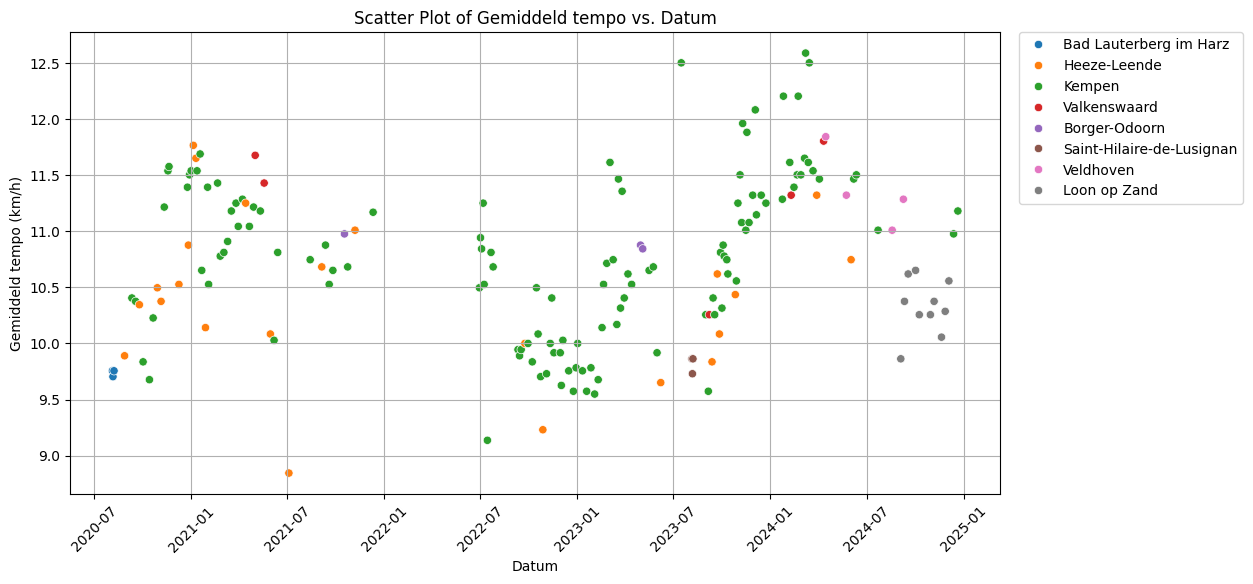

In [40]:
def plot_scatter(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='datum', y='tempo_km/h', hue='titel', data=df)

    plt.grid(True)
    plt.xlabel('Datum')
    plt.ylabel('Gemiddeld tempo (km/h)')
    plt.title('Scatter Plot of Gemiddeld tempo vs. Datum')
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0) 
    plt.xticks(rotation=45)
    plt.show()

plot_scatter(garmin_activities_prep)

C:\Users\michel.marien_icarew\AppData\Local\Temp\ipykernel_20792\1969944663.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)


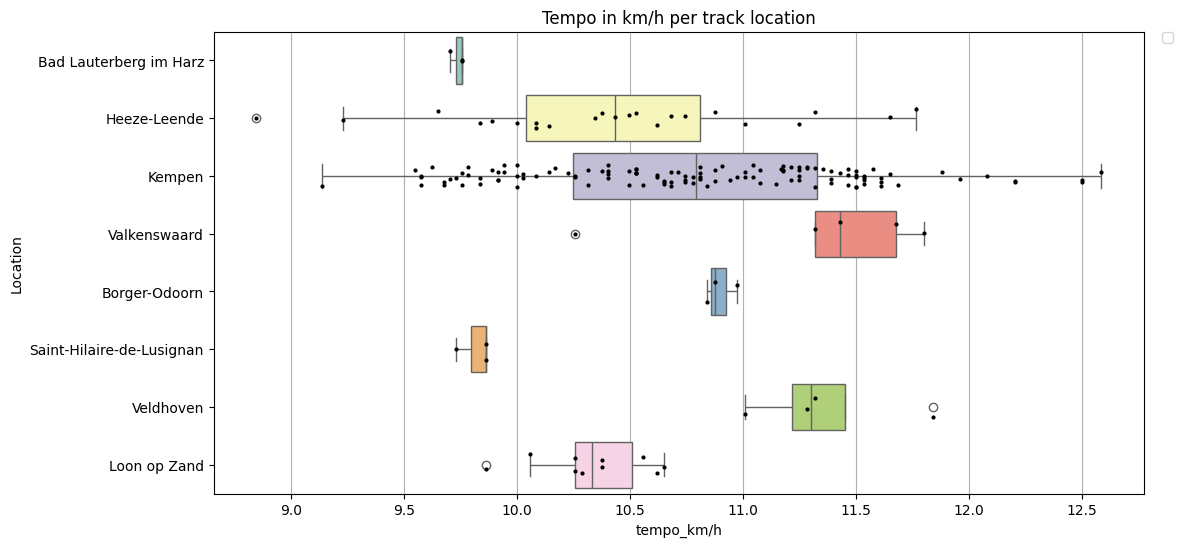

In [41]:
# Boxplot of track average speed per location
def plot_boxplot(df):
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    
    plt.grid(True)
    
    sns.boxplot(y='titel', x='tempo_km/h', data=df, hue='titel', palette="Set3", dodge=False)
    
    sns.stripplot(y='titel', x='tempo_km/h', data=df, color='black', size=3, jitter=0.2, dodge=False)  # Add individual data points

    plt.title("Tempo in km/h per track location")
    
    plt.ylabel("Location")
    
    plt.xlabel('tempo_km/h')
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0) 
    
    plt.show()

plot_boxplot(garmin_activities_prep)

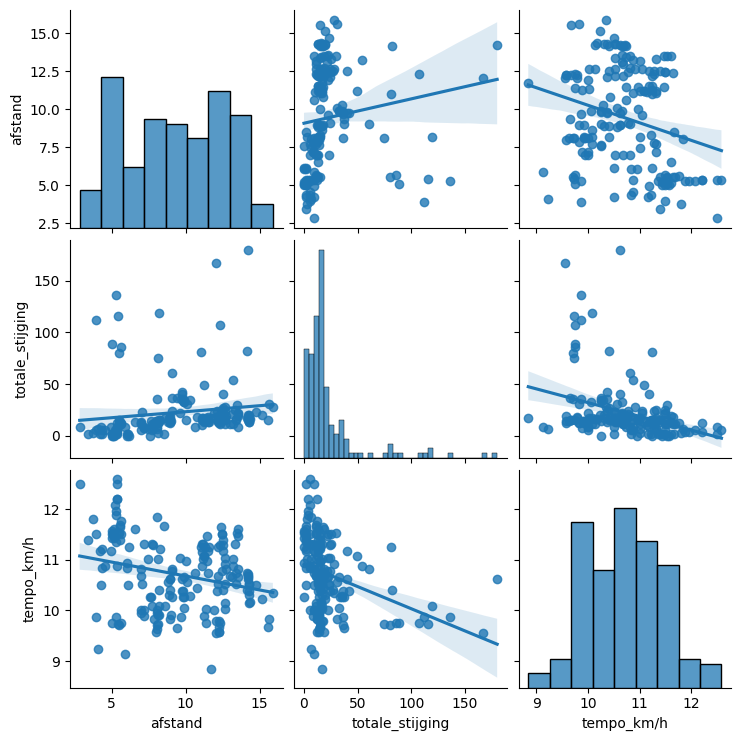

In [42]:
# Pairplot of garmin activities summary data frame
def plot_pairplot(df):
    ''' pair-plot of the numeric columns of df'''

    sns.pairplot(df, kind="reg")

    plt.show()

plot_pairplot(garmin_activities_prep)

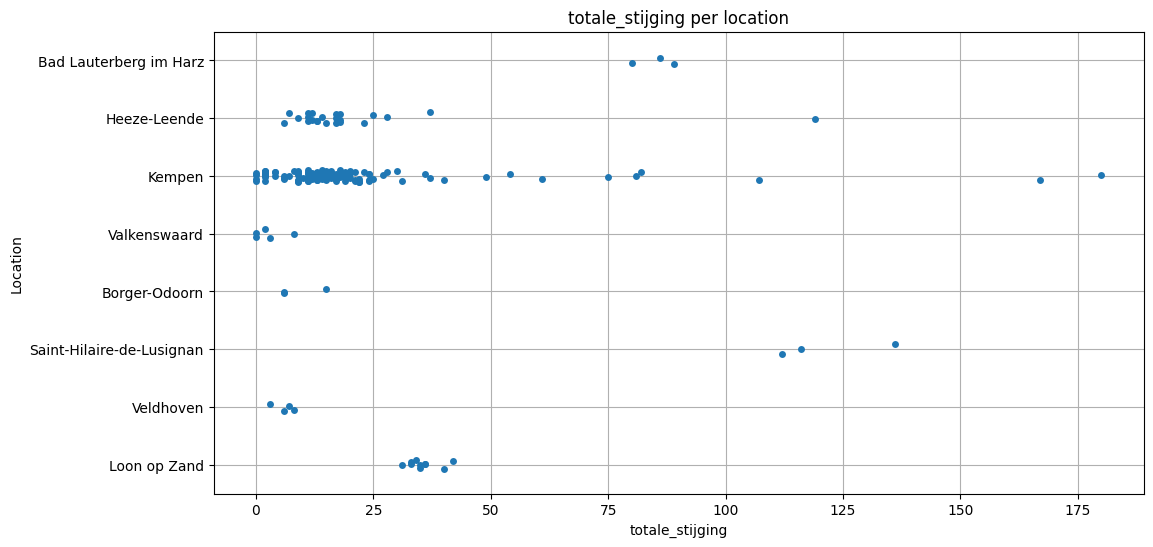

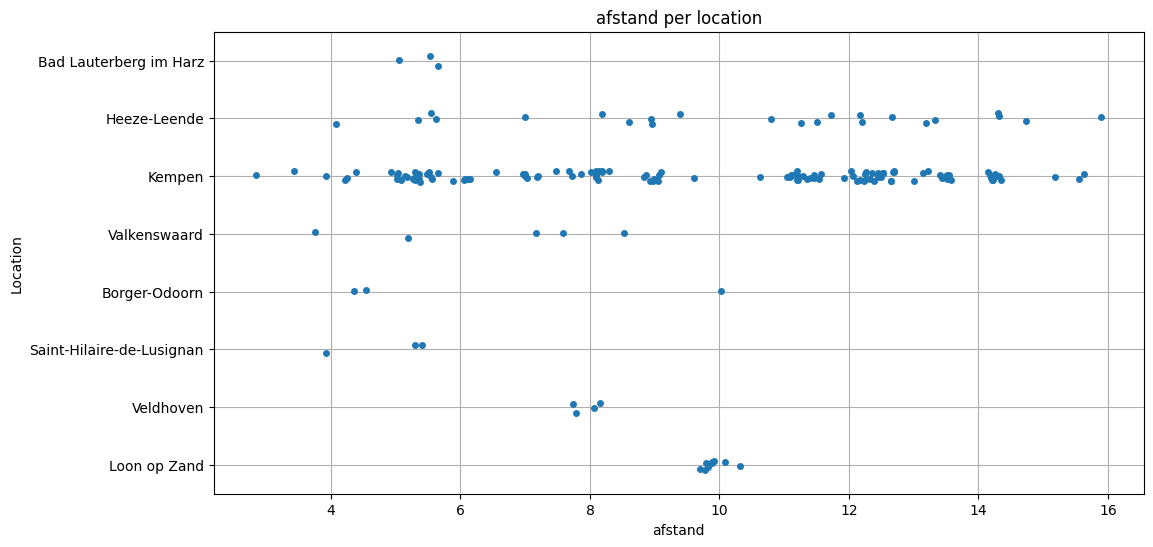

In [43]:
# Pairplot of garmin activities summary data frame
def plot_stripplot(df,y_col, x_col):
    ''' stripplot of x_col vs y_col'''

    plt.figure(figsize=(12, 6))

    sns.stripplot(y = x_col, x = y_col, data=df)

    plt.title(f"{y_col} per location") 

    plt.grid(True)

    plt.ylabel("Location")

    plt.xlabel(y_col)

    #plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

    plt.show()

plot_stripplot(garmin_activities_prep, 'totale_stijging', 'titel')
plot_stripplot(garmin_activities_prep, 'afstand', 'titel')


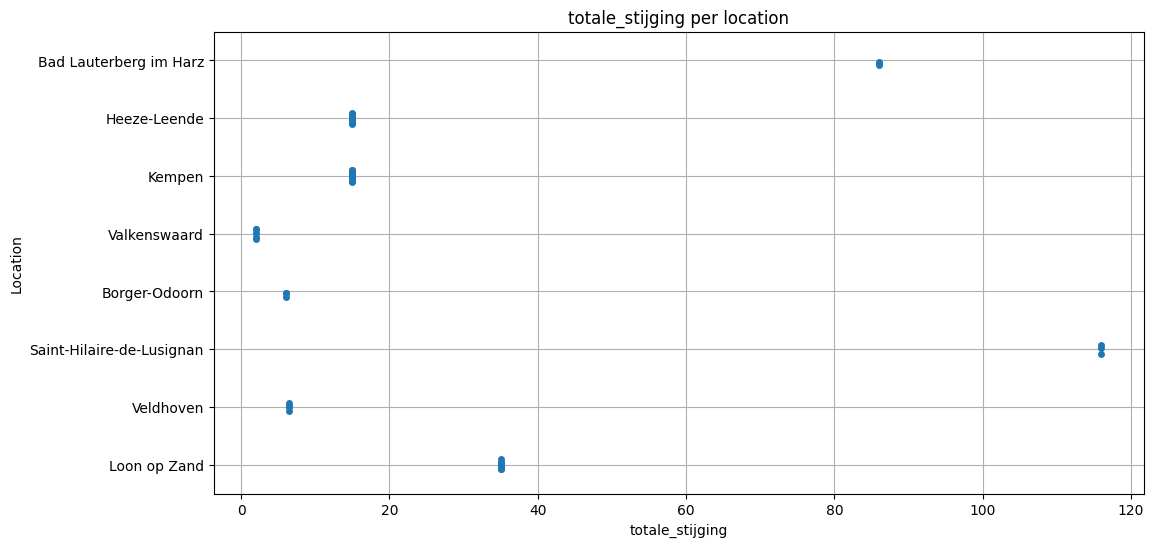

In [44]:
# removing outliers for 'totale stijging'"Course files
def change_to_median(df, col_to_median, group_col):
    ''' values in col_to_median in df are changed to median value based on group_col'''
    
    for col in col_to_median:
        
        df[col] = df.groupby(group_col)[col].transform('median') 

    return df

### apply function
col_to_median = ['totale_stijging']
group_col = ['titel']

garmin_activities_prep = change_to_median(garmin_activities_prep, col_to_median, group_col)
plot_stripplot(garmin_activities_prep, 'totale_stijging', 'titel')

In [45]:
garmin_activities_prep

datum                   titel  afstand  totale_stijging  \
0   2020-08-04 17:04:00  Bad Lauterberg im Harz     5.66             86.0   
1   2020-08-05 17:19:00  Bad Lauterberg im Harz     5.53             86.0   
2   2020-08-07 17:15:00  Bad Lauterberg im Harz     5.05             86.0   
3   2020-08-27 16:47:00            Heeze-Leende    11.26             15.0   
4   2020-09-10 12:35:00                  Kempen    12.53             15.0   
..                  ...                     ...      ...              ...   
170 2024-11-19 16:06:00            Loon op Zand     9.88             35.0   
171 2024-11-26 15:56:00            Loon op Zand    10.31             35.0   
172 2024-12-03 15:56:00            Loon op Zand    10.08             35.0   
173 2024-12-12 13:54:00                  Kempen    11.46             15.0   
174 2024-12-20 15:38:00                  Kempen    11.54             15.0   

    tracklengths  tempo_km/h  
0              8       9.756  
1              8       9.704  
2              8       9.756  
3             12       9.890  
4             20      10.405  
..           ...         ...  
170           12      10.056  
171           12      10.286  
172           12      10.557  
173           12      10.976  
174           12      11.180  

[175 rows x 6 columns]

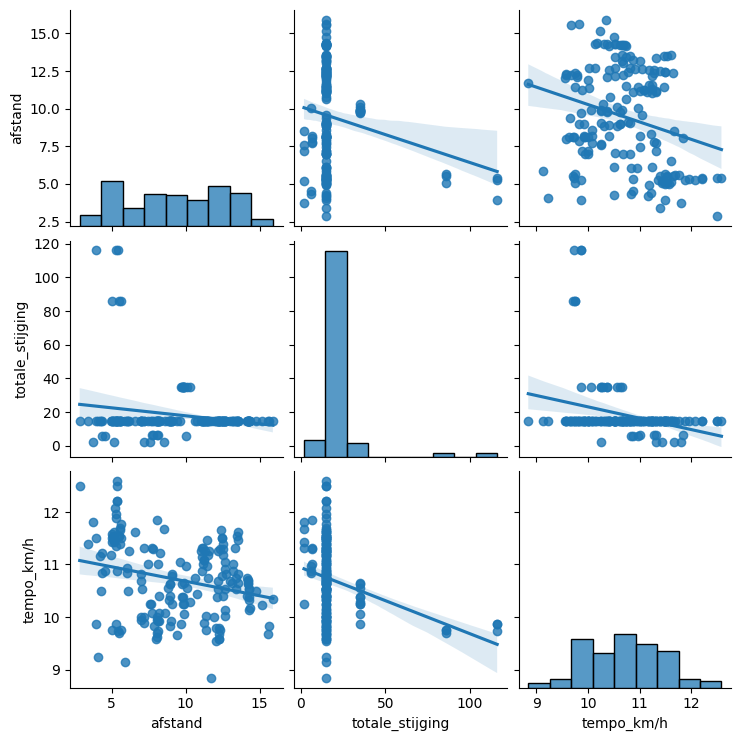

In [58]:
# Pairplot of garmin_activities_prep data frame
plot_pairplot(garmin_activities_prep)

### Garmin additional features data frame

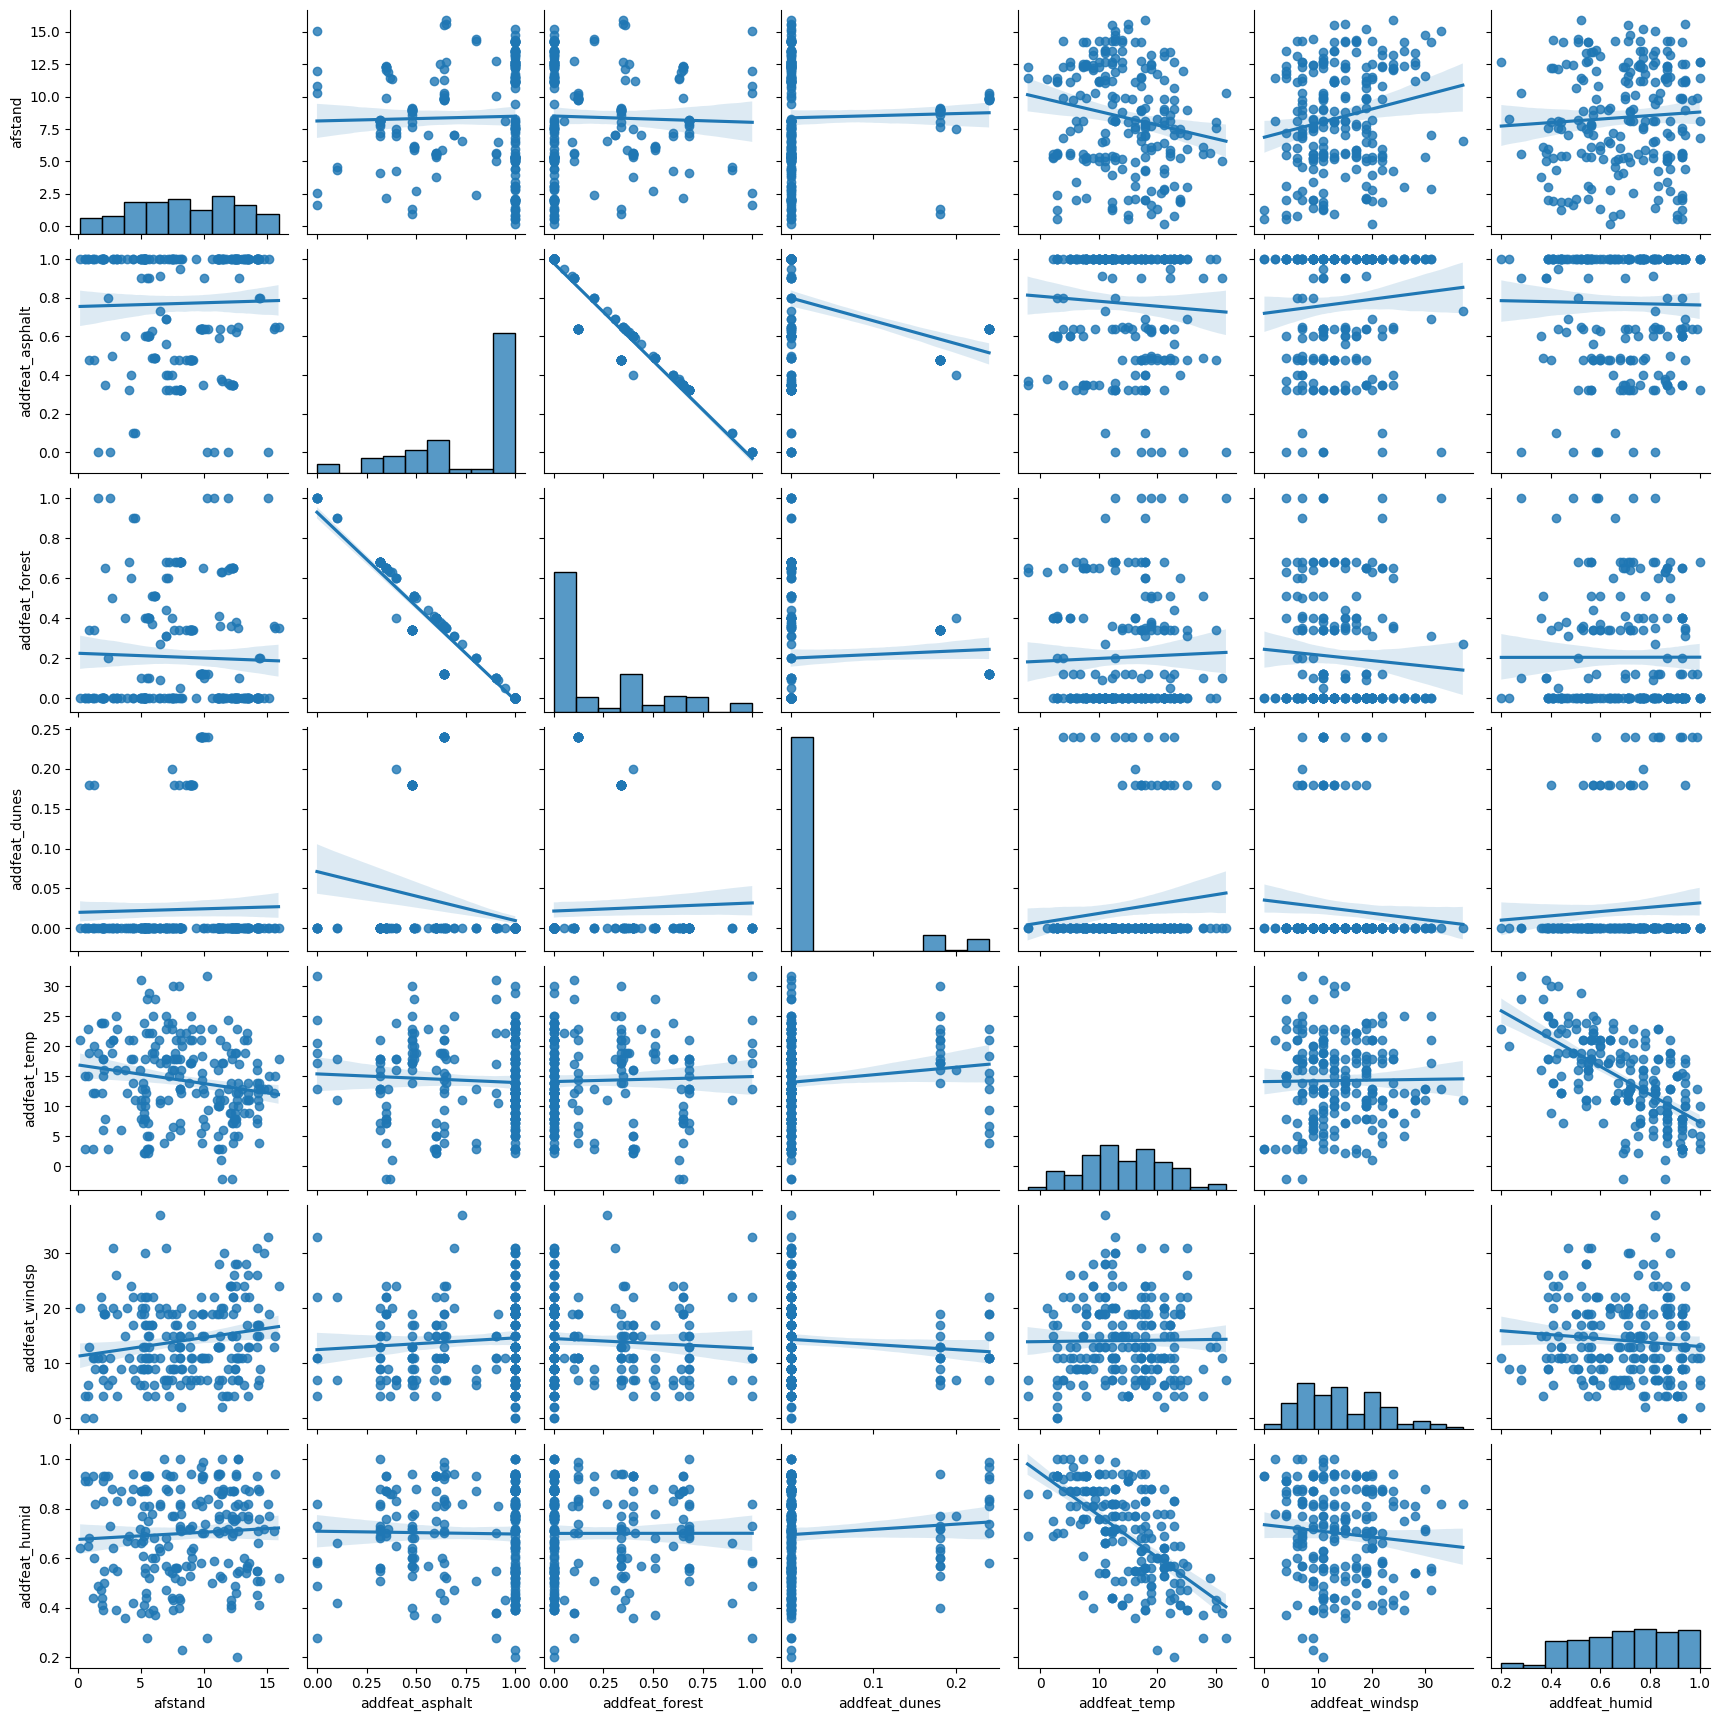

In [46]:
# Pairplot of garmin additional features data frame
plot_pairplot(garmin_addfeatures_prep)

## Regression analysis 1: Location based regression

### Prepare dataset for regression analysis

In [47]:
garmin_activities_prep.head()

datum                   titel  afstand  totale_stijging  \
0 2020-08-04 17:04:00  Bad Lauterberg im Harz     5.66             86.0   
1 2020-08-05 17:19:00  Bad Lauterberg im Harz     5.53             86.0   
2 2020-08-07 17:15:00  Bad Lauterberg im Harz     5.05             86.0   
3 2020-08-27 16:47:00            Heeze-Leende    11.26             15.0   
4 2020-09-10 12:35:00                  Kempen    12.53             15.0   

  tracklengths  tempo_km/h  
0            8       9.756  
1            8       9.704  
2            8       9.756  
3           12       9.890  
4           20      10.405

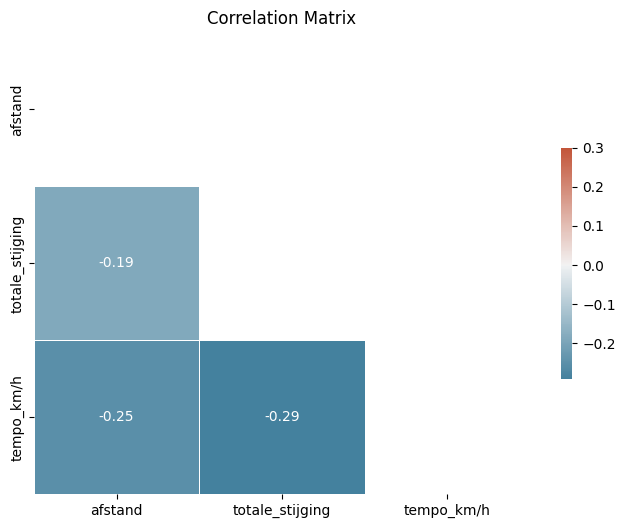

afstand  totale_stijging  tempo_km/h
afstand          1.000000        -0.187543   -0.252398
totale_stijging -0.187543         1.000000   -0.291398
tempo_km/h      -0.252398        -0.291398    1.000000

In [48]:
# correlation plot
def correlation_plot(df, non_num_cols):
    ''' create correlation heatmap'''

    matrix_cor = df.drop(non_num_cols, axis=1).corr()

    plt.figure(figsize=(8, 6))  # Adjust figure size as needed

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    mask = np.triu(np.ones_like(matrix_cor, dtype=bool))

    sns.heatmap(matrix_cor,  cmap = cmap, vmax=.3, center=0, square=False, 
                linewidths=.5, cbar_kws={"shrink": .5}, mask = mask, annot=True)
    
    plt.title("Correlation Matrix")
    
    plt.show()

    return matrix_cor


# Create correlation plot
drop_cols = ['datum', 'titel', 'tracklengths']

df_correlation = correlation_plot(garmin_activities_prep, drop_cols)
df_correlation

### Regression analysis

In [49]:
# Filer data set based on correlation threshold
def filter_dataset(df, cor_matrix, target_column, corr_threshold):
    ''' filter df columns based on the corr_threshold for the target_column in cor_matrix'''

    filtered_cols = [col for col in cor_matrix.columns if abs(cor_matrix[col][target_column]) > corr_threshold and col != target_column]
    
    filtered_cols.append('tempo_km/h')

    df_filtered = df[filtered_cols]

    return df_filtered


# Normalize data
def normalize_data(df):
    ''' normalize data in df '''

    scaler = MinMaxScaler()

    # Fit the scaler to the data and transform it
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    return df_normalized

# Combine functions
def create_reg_dataset(df, cor_matrix, target_column, corr_treshold):

    df = filter_dataset(df, cor_matrix, target_column, corr_treshold)

    df = normalize_data(df)

    return df

### Apply functions
corr_treshold = 0.15
target_column = 'tempo_km/h'

loc_based_multivar_reg = create_reg_dataset(garmin_activities_prep, df_correlation, target_column, corr_treshold)

#loc_based_multivar_reg.head()


In [50]:
# Create multivariate regression models

def _create_bins(y, n_bins=10):
    """Creates bins for stratification based on the target variable."""
    kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = kbd.fit_transform(y.values.reshape(-1, 1)).ravel()
    return y_binned

def _resample_within_bins(combined_data, y_binned, random_state=1):
    """Performs resampling within each bin."""
    unique_bins = np.unique(y_binned)
    resampled_data = []
    for bin_val in unique_bins:
        bin_indices = np.where(y_binned == bin_val)[0]
        bin_data = combined_data[bin_indices]
        resampled_bin = resample(bin_data, n_samples=len(bin_indices), random_state=random_state)
        resampled_data.append(resampled_bin)
    return resampled_data

def stratified_resample(X, y, n_bins=10, random_state=1):
    """
    Perform stratified resampling for regression problems by binning the target variable.
    """
    y_binned = _create_bins(y, n_bins)
    combined_data = np.column_stack([X, y])
    resampled_data = _resample_within_bins(combined_data, y_binned, random_state)
    resampled_combined = np.vstack(resampled_data)
    np.random.shuffle(resampled_combined)
    X_resampled = resampled_combined[:, :-1]
    y_resampled = resampled_combined[:, -1]
    
    # Convert resampled data back to DataFrames
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns, index=X.index)  
    y_resampled = pd.Series(y_resampled, name=y.name, index=y.index)

    return X_resampled, y_resampled

def _prepare_data(df, target_column):
    """Prepares data for analysis, including feature and target separation."""
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y

def _create_polynomial_features(X_train, X_val, X_test, degree):
    """Creates polynomial features for the given datasets, including feature names."""
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Fit and transform training data
    X_train_poly = poly.fit_transform(X_train)
    X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_train.index)

    # Transform validation and test data
    X_val_poly = poly.transform(X_val)
    X_val_poly = pd.DataFrame(X_val_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_val.index)  
    
    X_test_poly = poly.transform(X_test)
    X_test_poly = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(X_train.columns), index=X_test.index)  
    
    return X_train_poly, X_val_poly, X_test_poly

def plot_model_performance(y, y_test, y_test_pred, degree):
    """Creates and displays the actual vs predicted and residual plots with index annotations."""
    plt.figure(figsize=(12, 5))

    # Actual vs Predicted Plot with Index Annotations
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5, label='Test')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted (Degree {degree})')
    plt.legend()
    
    # Annotate points with index numbers
    for i, (actual, pred) in enumerate(zip(y_test, y_test_pred)):
        plt.annotate(y_test.index[i], (actual, pred), textcoords="offset points", xytext=(0,10), ha='center') 


    # Residual Plot with Index Annotations
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, y_test - y_test_pred, alpha=0.5, label='Test')
    plt.axhline(y=0, color='k', linestyle='--')
    
    # Annotate points with index numbers
    for i, (pred, resid) in enumerate(zip(y_test_pred, y_test - y_test_pred)):
        plt.annotate(y_test.index[i], (pred, resid), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot (Degree {degree})')
    plt.legend()

    plt.tight_layout()
    plt.show()


def _train_model(X_train_poly, y_train):
    """Trains a Linear Regression model."""
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    return model

def _evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test, k=5):
    """Evaluates the model using cross-validation and calculates metrics."""
    cv_scores = cross_val_score(model, X_train_poly, y_train, cv=k, scoring='r2')
    train_r2 = model.score(X_train_poly, y_train)
    val_r2 = model.score(X_val_poly, y_val)
    test_r2 = model.score(X_test_poly, y_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train_poly)))
    val_rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val_poly)))
    test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_poly)))
    return {
        'Train R2': train_r2,
        'Validation R2': val_r2,
        'Test R2': test_r2,
        'Cross-Validation R2 Mean': cv_scores.mean(),
        'Cross-Validation R2 Std': cv_scores.std(),
        'Train RMSE': train_rmse,
        'Validation RMSE': val_rmse,
        'Test RMSE': test_rmse
    }

def _train_and_evaluate_model(X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test, degree, k=5):  # Add degree as input
    """Trains, evaluates, and plots the performance of a Linear Regression model."""
    model = _train_model(X_train_poly, y_train)
    metrics = _evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test, k)

    # Make predictions and plot
    y_test_pred = model.predict(X_test_poly)
    plot_model_performance(y_train, y_test, y_test_pred, degree)

    return metrics

def run_multivariate_analysis(df, target_column, degrees=[1], k=5, train_size=0.6, val_size=0.2, test_size=0.2, n_bins=10, random_state=1):
    """
    Run complete multivariate regression analysis with polynomial feature expansion and stratified k-fold cross-validation.
    """
    X, y = _prepare_data(df, target_column)
    
    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (val_size + test_size), random_state=random_state)
    
    results = []
    for degree in degrees:
        X_train_poly, X_val_poly, X_test_poly = _create_polynomial_features(X_train, X_val, X_test, degree)
        model_results = _train_and_evaluate_model(X_train_poly, y_train, X_val_poly, y_val, X_test_poly, y_test, degree, k) 
        results.append({'Degree': degree, **model_results}) 

    return pd.DataFrame(results)


In [51]:
# General hyper parameters
degrees = [1, 2, 3]
random_states = np.random.randint(0, 100, size=5)

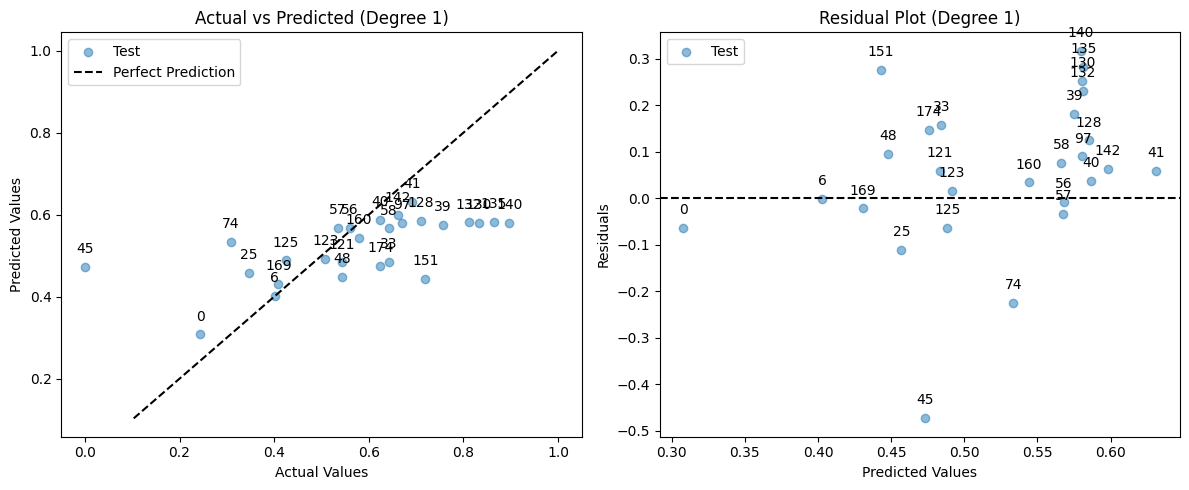

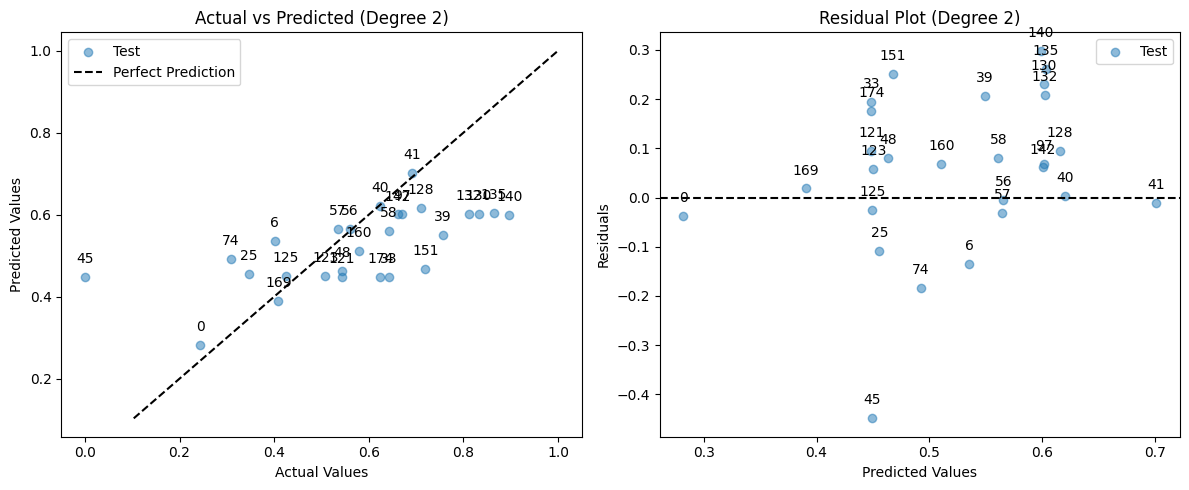

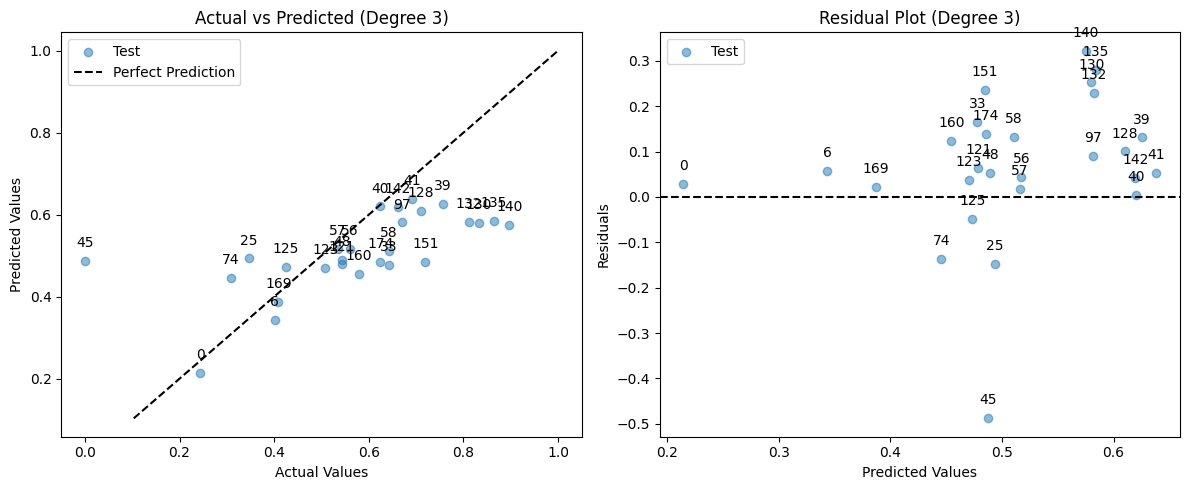

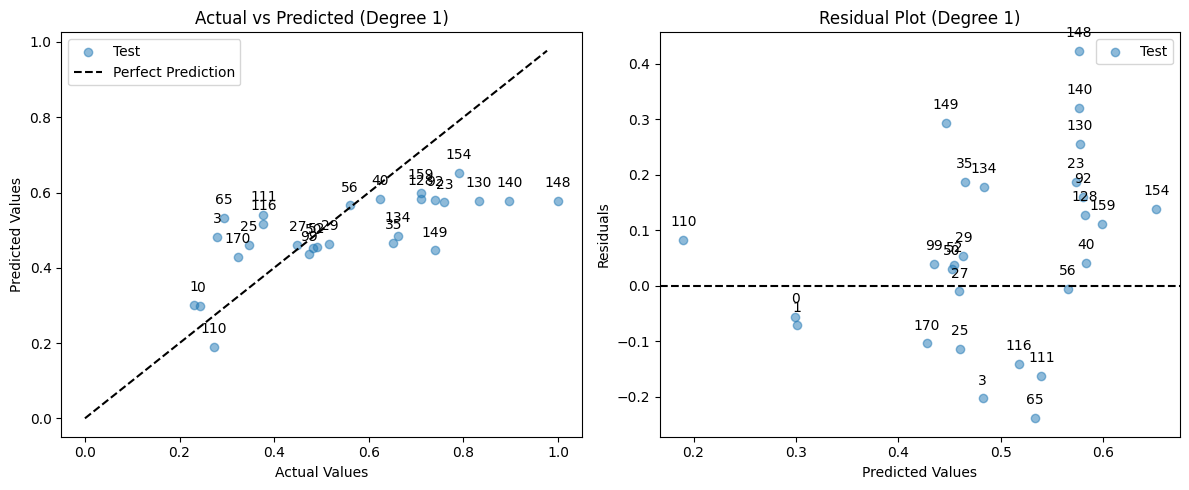

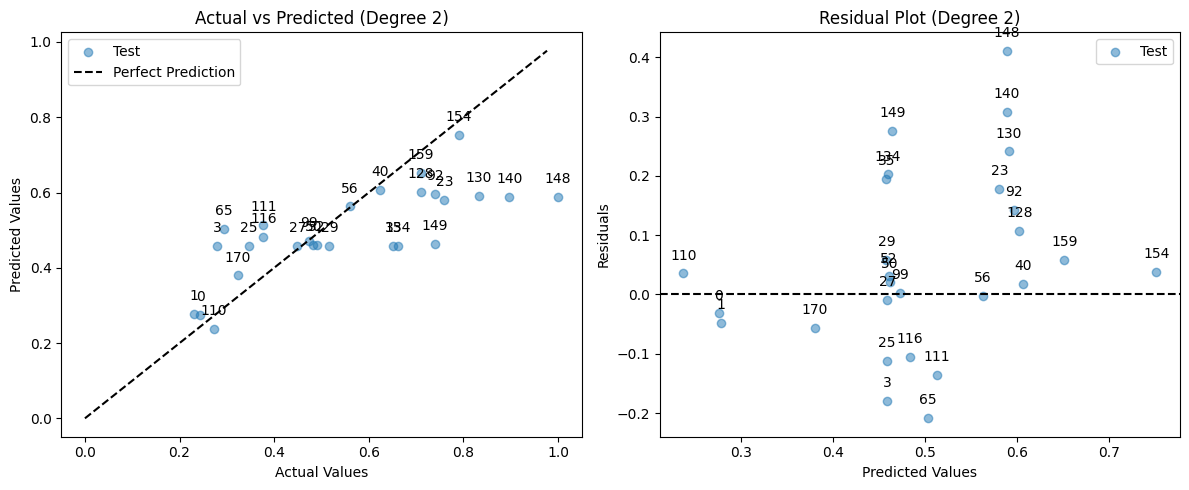

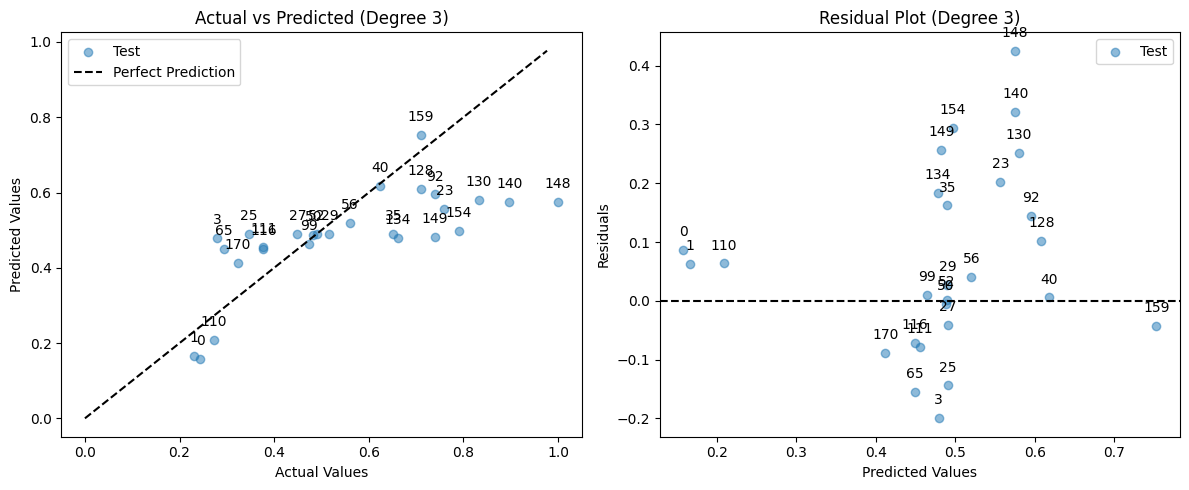

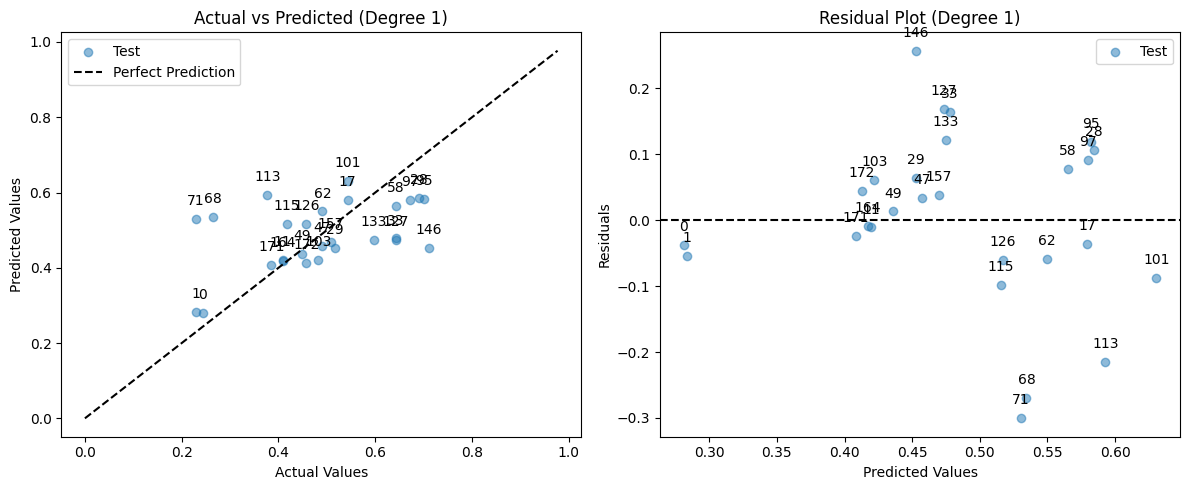

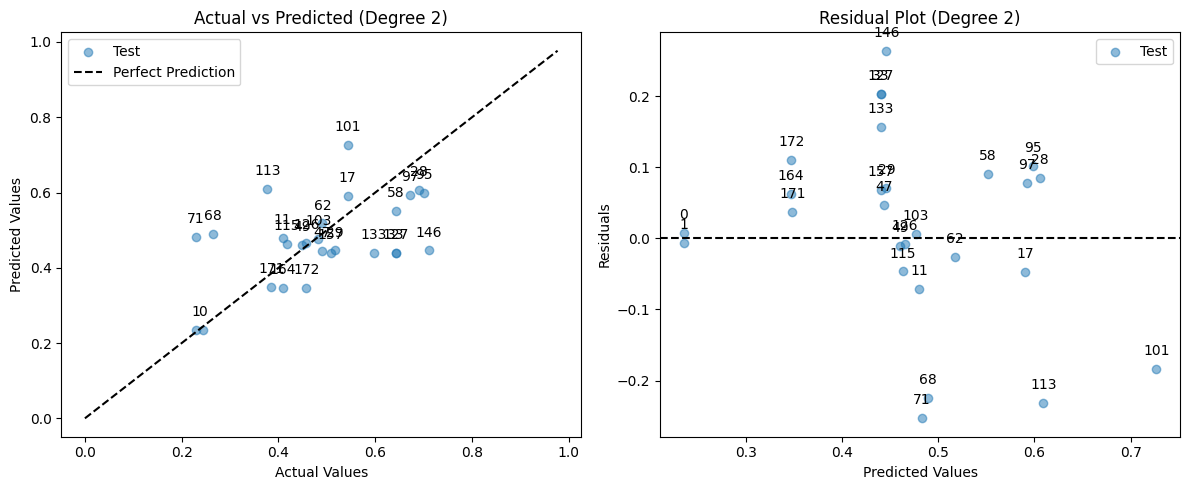

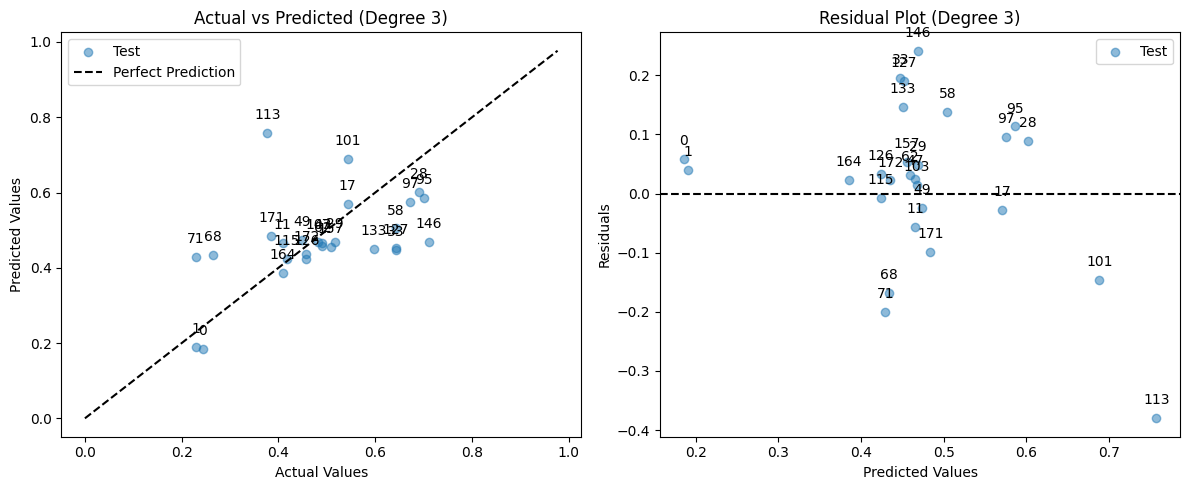

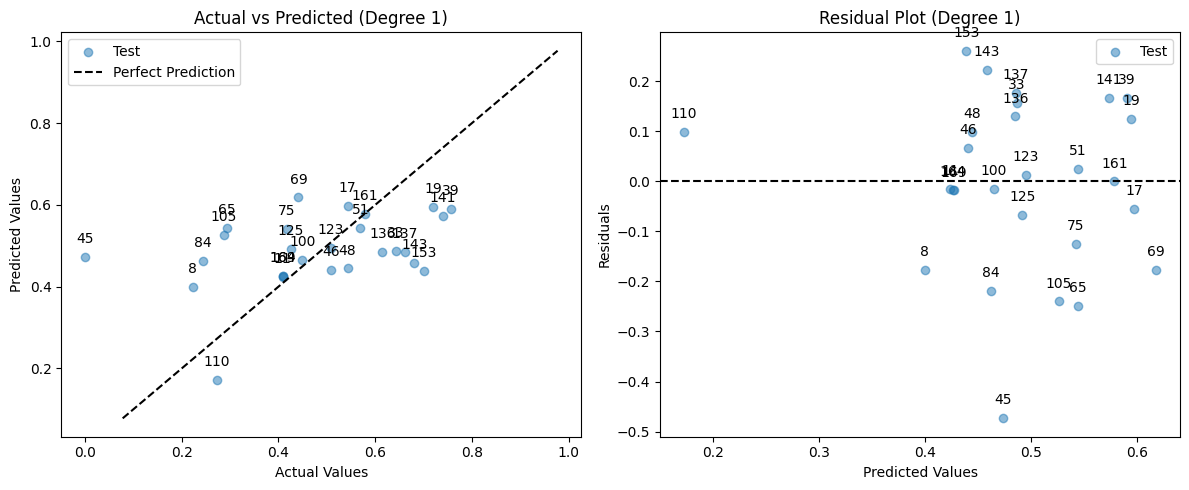

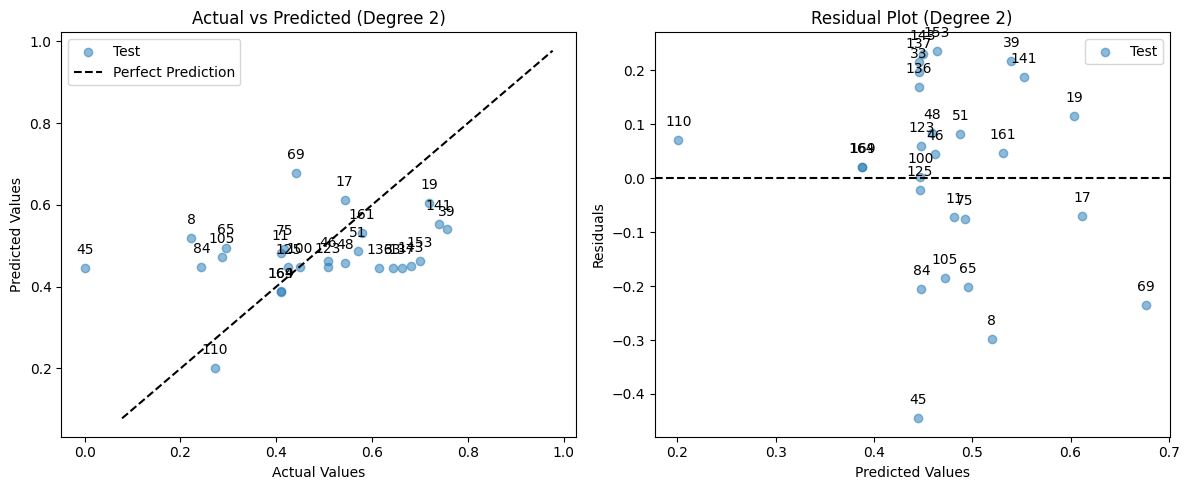

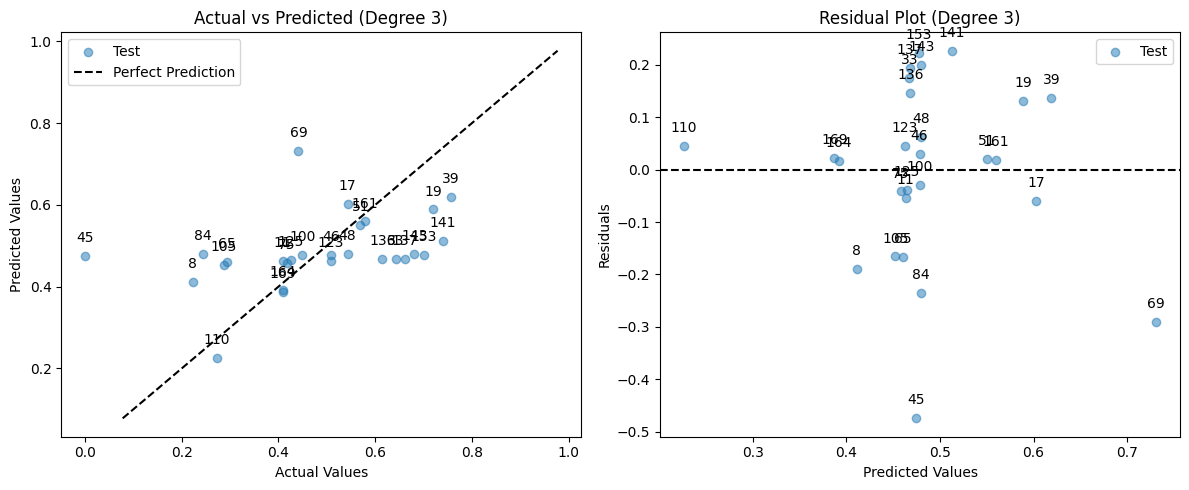

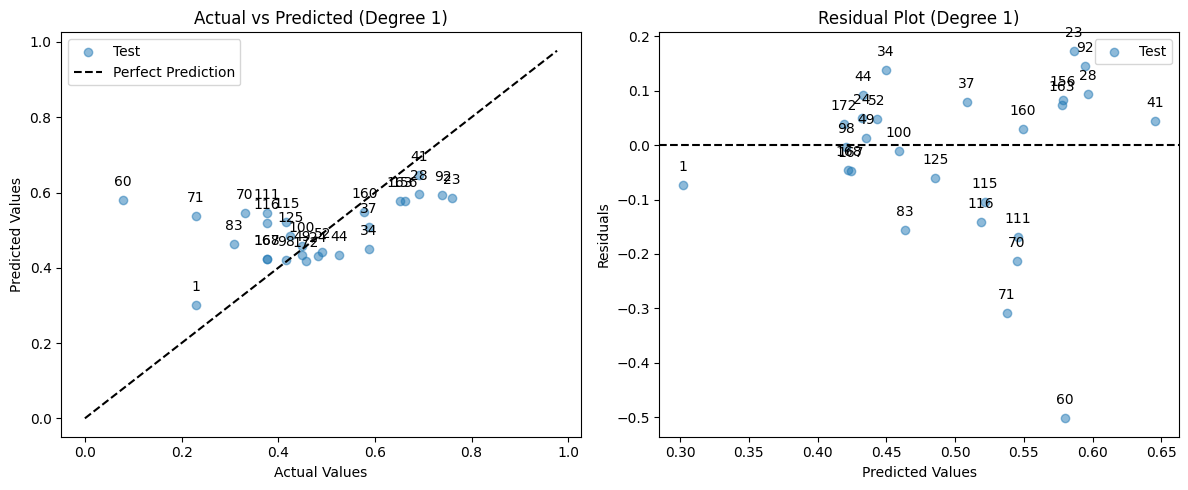

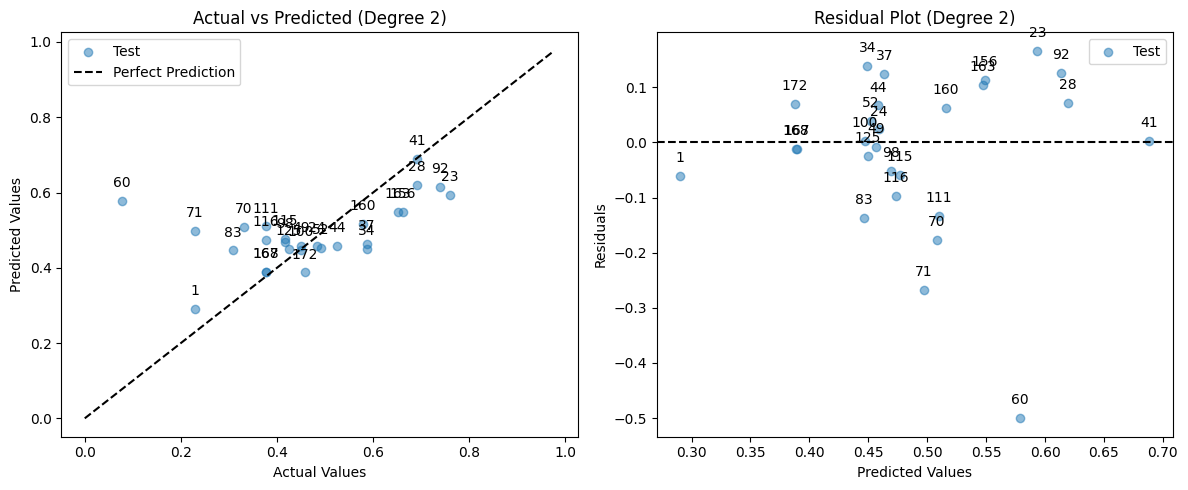

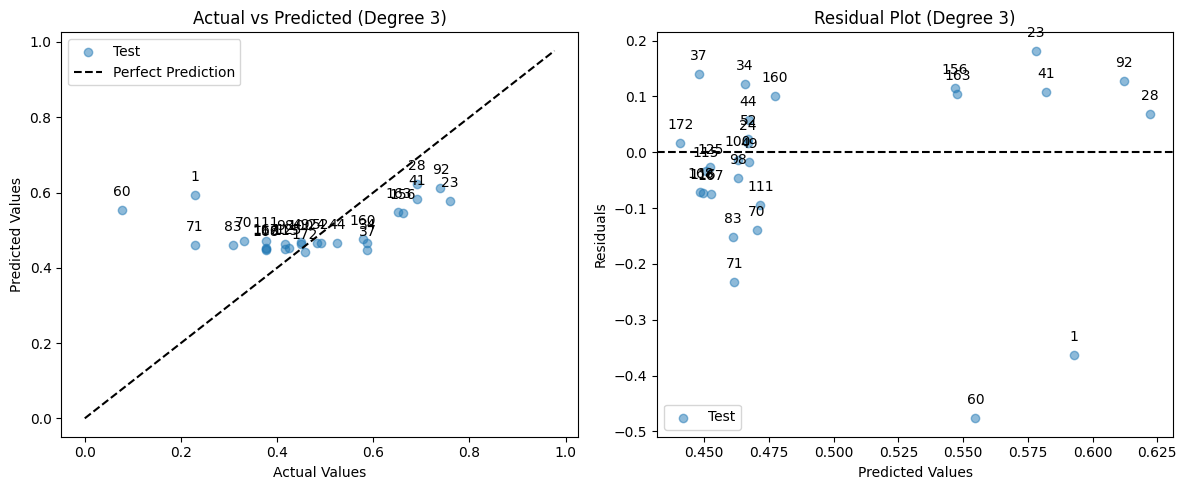


Averaged Model Performance for Different Polynomial Degrees:
        Train R2  Validation R2   Test R2  Cross-Validation R2 Mean  Cross-Validation R2 Std  Train RMSE  Validation RMSE  Test RMSE
Degree                                                                                                                              
1       0.170095       0.046176  0.226551                  0.054636                 0.269946    0.176300         0.184420   0.157715
2       0.217145       0.128266  0.256525                  0.086052                 0.261853    0.171216         0.176741   0.153682
3       0.275502      -0.732397  0.225353                 -3.534531                 7.953303    0.164706         0.238242   0.157155


In [52]:
df = loc_based_multivar_reg

all_results = []
for random_state in random_states:
    results = run_multivariate_analysis(
        df,
        random_state=random_state,
        target_column='tempo_km/h',
        degrees=degrees,
        k=10,
        train_size=0.7,
        val_size=0.15,
        test_size=0.15
    )
    all_results.append(results)

# Average the results
averaged_results = pd.concat(all_results).groupby('Degree').mean()

# Print averaged results table
print("\nAveraged Model Performance for Different Polynomial Degrees:")
print(averaged_results.to_string())

## Regression analysis 2: Additional features based regression

### Prepare dataset for regression analysis

In [53]:
# Garmin activities joined with additional features data frame
garmin_activities_prep['datum'] = pd.to_datetime(garmin_activities_prep['datum'])
garmin_addfeatures_prep['datum'] = pd.to_datetime(garmin_addfeatures_prep['datum'])

# Perform left join
def join_datasets(df1, df2, cols_to_drop):
    ''' join activities and additional features datasets and drop uninformative columns'''
    
    df_total = pd.merge(
        df1,
        df2,
        on=['datum'],
        how='left')
    
    df_total.drop(cols_to_drop, axis = 1, inplace= True)

    df_total = df_total.rename(columns={'afstand_x': 'afstand'}) 

    return df_total

### Apply functions

drop_cols = ['datum','titel','afstand_y' ,'plaats','tracklengths', 'addfeat_sky','addfeat_winddir']

garmin_act_extended = join_datasets(garmin_activities_prep, garmin_addfeatures_prep, drop_cols)
garmin_act_extended.head()

afstand  totale_stijging  tempo_km/h  addfeat_asphalt  addfeat_forest  \
0     5.66             86.0       9.756             0.90            0.10   
1     5.53             86.0       9.704             0.90            0.10   
2     5.05             86.0       9.756             0.90            0.10   
3    11.26             15.0       9.890             0.64            0.36   
4    12.53             15.0      10.405             0.62            0.38   

   addfeat_dunes  addfeat_temp  addfeat_windsp  addfeat_humid  
0            0.0          22.2              15           0.38  
1            0.0          27.8               9           0.28  
2            0.0          31.1              11           0.38  
3            0.0          21.1              15           0.53  
4            0.0          18.9              11           0.46

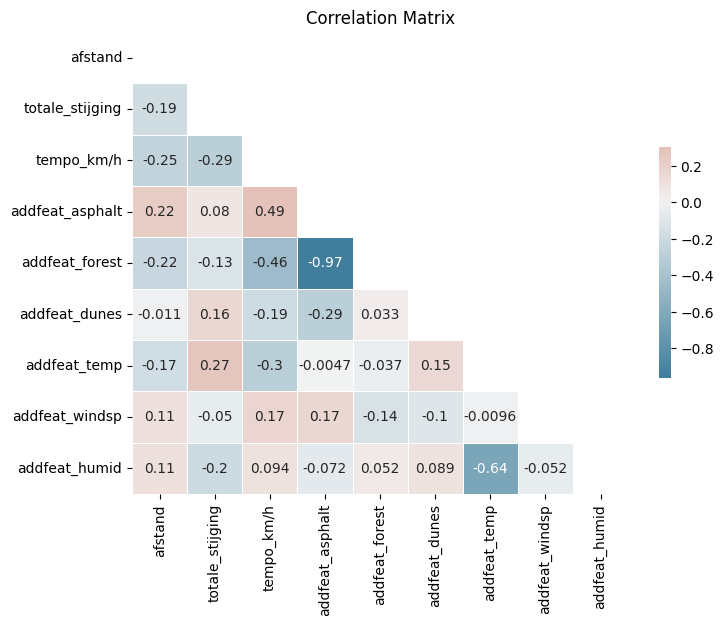

afstand  totale_stijging  tempo_km/h  addfeat_asphalt  \
afstand          1.000000        -0.187543   -0.252398         0.216569   
totale_stijging -0.187543         1.000000   -0.291398         0.080160   
tempo_km/h      -0.252398        -0.291398    1.000000         0.490841   
addfeat_asphalt  0.216569         0.080160    0.490841         1.000000   
addfeat_forest  -0.223091        -0.127021   -0.460296        -0.965919   
addfeat_dunes   -0.010843         0.160061   -0.194082        -0.290914   
addfeat_temp    -0.167473         0.265239   -0.299692        -0.004685   
addfeat_windsp   0.110187        -0.050001    0.172370         0.165933   
addfeat_humid    0.106820        -0.198370    0.094334        -0.072420   

                 addfeat_forest  addfeat_dunes  addfeat_temp  addfeat_windsp  \
afstand               -0.223091      -0.010843     -0.167473        0.110187   
totale_stijging       -0.127021       0.160061      0.265239       -0.050001   
tempo_km/h            -0.460296      -0.194082     -0.299692        0.172370   
addfeat_asphalt       -0.965919      -0.290914     -0.004685        0.165933   
addfeat_forest         1.000000       0.033364     -0.036593       -0.144993   
addfeat_dunes          0.033364       1.000000      0.151928       -0.103979   
addfeat_temp          -0.036593       0.151928      1.000000       -0.009626   
addfeat_windsp        -0.144993      -0.103979     -0.009626        1.000000   
addfeat_humid          0.051832       0.088715     -0.635119       -0.051660   

                 addfeat_humid  
afstand               0.106820  
totale_stijging      -0.198370  
tempo_km/h            0.094334  
addfeat_asphalt      -0.072420  
addfeat_forest        0.051832  
addfeat_dunes         0.088715  
addfeat_temp         -0.635119  
addfeat_windsp       -0.051660  
addfeat_humid         1.000000

In [54]:
# Create correlation plot
drop_cols = []

df_correlation = correlation_plot(garmin_act_extended, drop_cols)

df_correlation

### Regression analysis

In [55]:
# Filer data set based on correlation threshold
def filter_dataset(df, cor_matrix, target_column, corr_threshold):
    ''' filter df columns based on the corr_threshold for the target_column in cor_matrix'''

    filtered_cols = [col for col in cor_matrix.columns if abs(cor_matrix[col][target_column]) > corr_threshold and col != target_column]
    
    filtered_cols.append('tempo_km/h')

    df_filtered = df[filtered_cols]

    return df_filtered


# Normalize data
def normalize_data(df):
    ''' normalize data in df '''

    scaler = MinMaxScaler()

    # Fit the scaler to the data and transform it
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    return df_normalized

# Combine functions
def create_reg_dataset(df, cor_matrix, target_column, corr_treshold):

    df = filter_dataset(df, cor_matrix, target_column, corr_treshold)

    df = normalize_data(df)

    return df

### Apply functions
corr_treshold = 0.18
target_column = 'tempo_km/h'

addfeature_based_multivar_reg = create_reg_dataset(garmin_act_extended, df_correlation, target_column, corr_treshold)

addfeature_based_multivar_reg.head()

afstand  totale_stijging  addfeat_asphalt  addfeat_forest  addfeat_dunes  \
0  0.215926         0.736842         0.888889        0.111111            0.0   
1  0.205972         0.736842         0.888889        0.111111            0.0   
2  0.169219         0.736842         0.888889        0.111111            0.0   
3  0.644717         0.114035         0.600000        0.400000            0.0   
4  0.741960         0.114035         0.577778        0.422222            0.0   

   addfeat_temp  tempo_km/h  
0      0.732733    0.243453  
1      0.900901    0.229556  
2      1.000000    0.243453  
3      0.699700    0.279262  
4      0.633634    0.416889

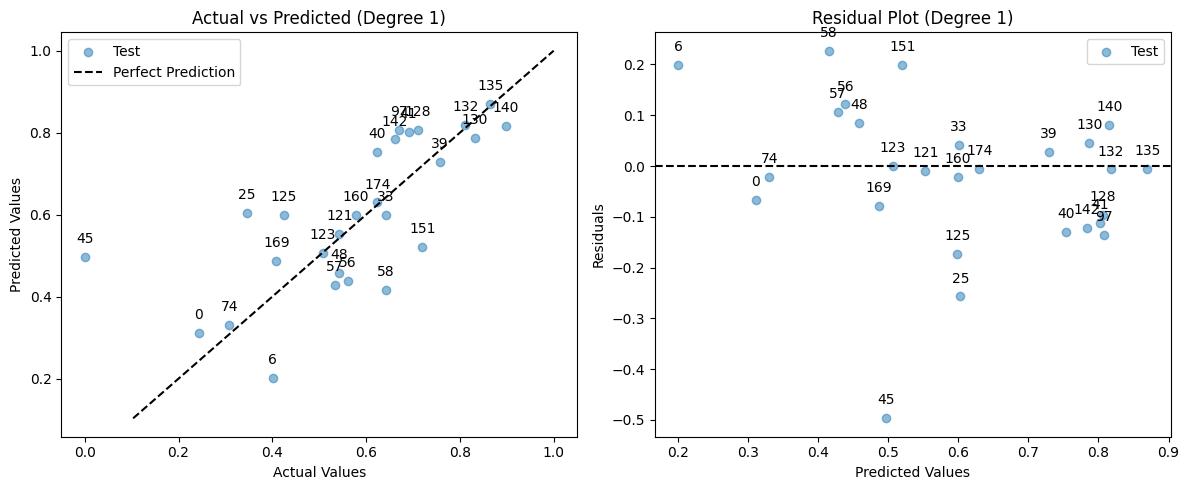

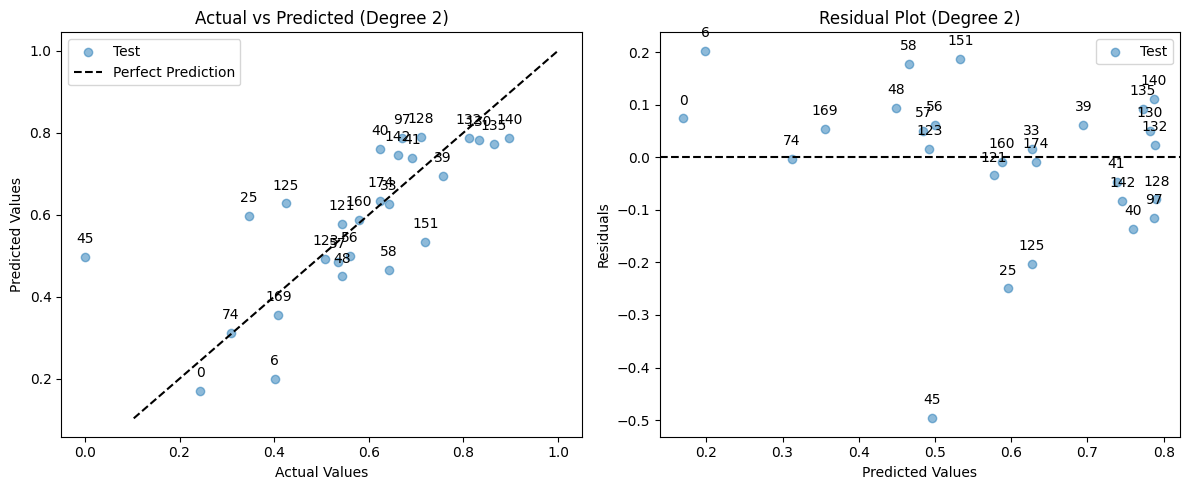

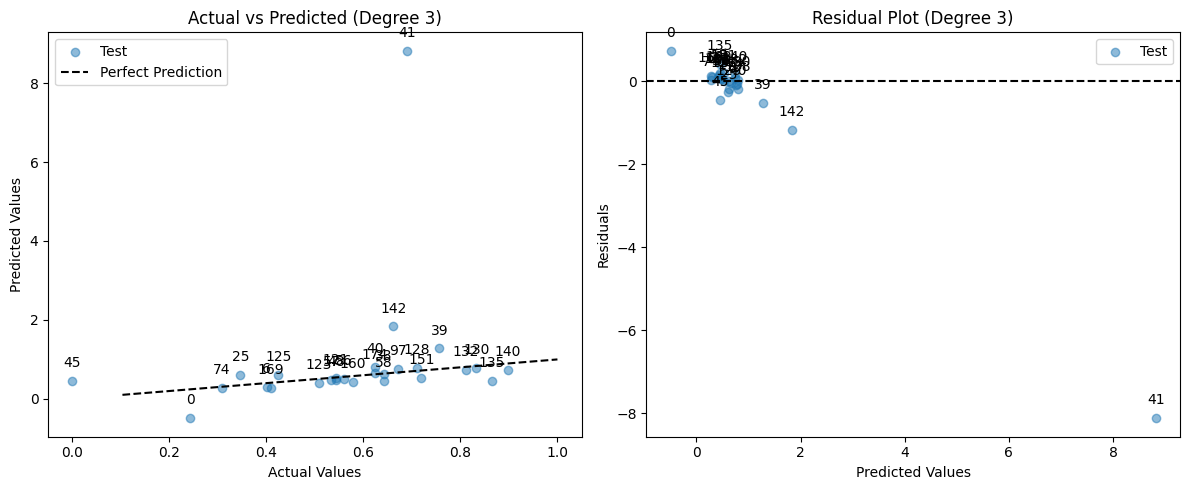

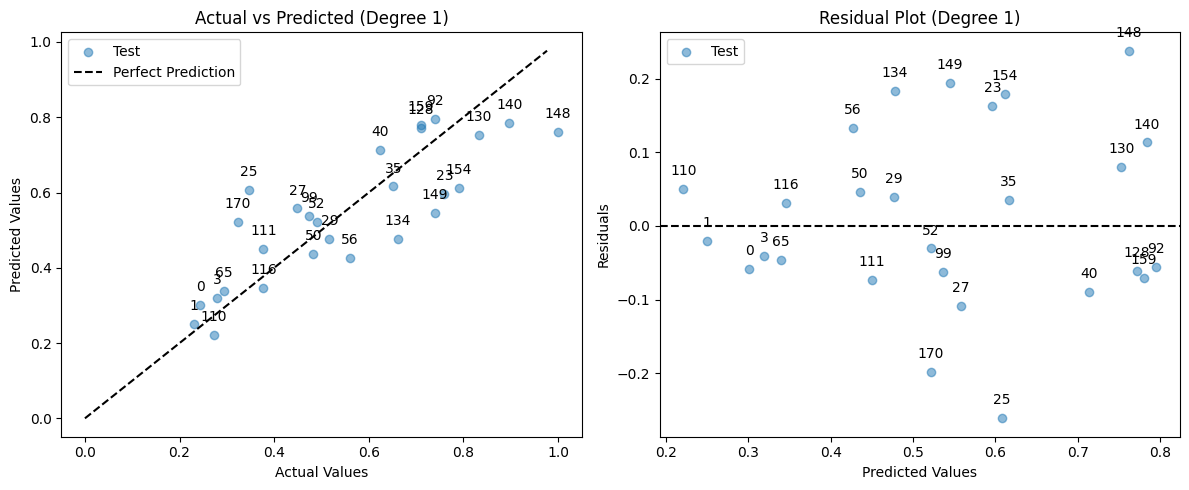

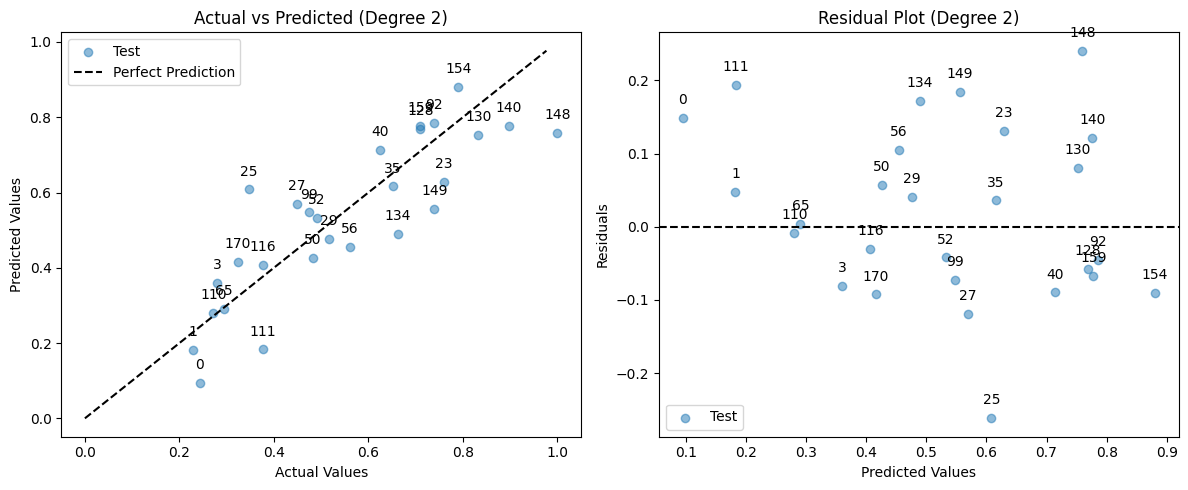

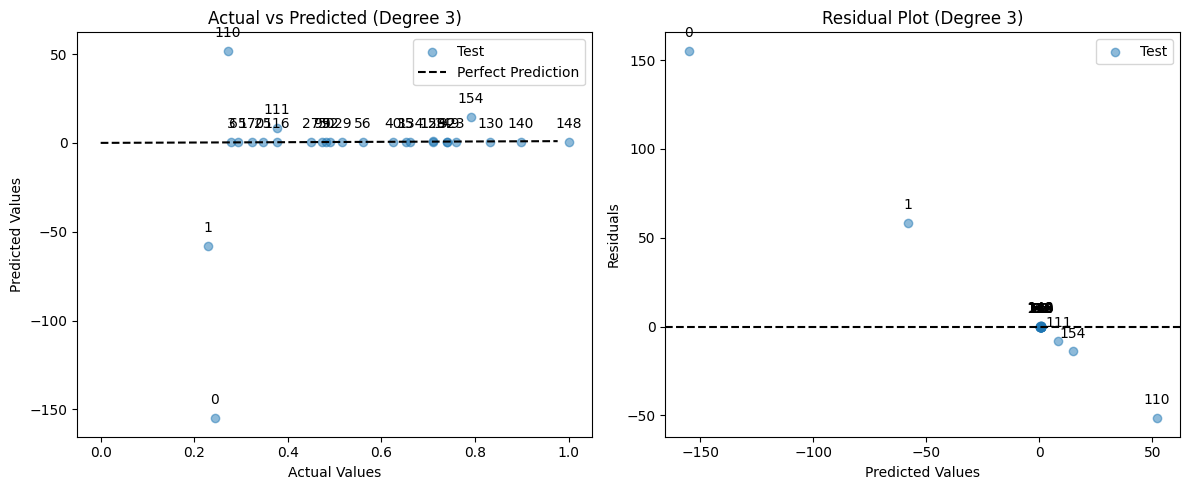

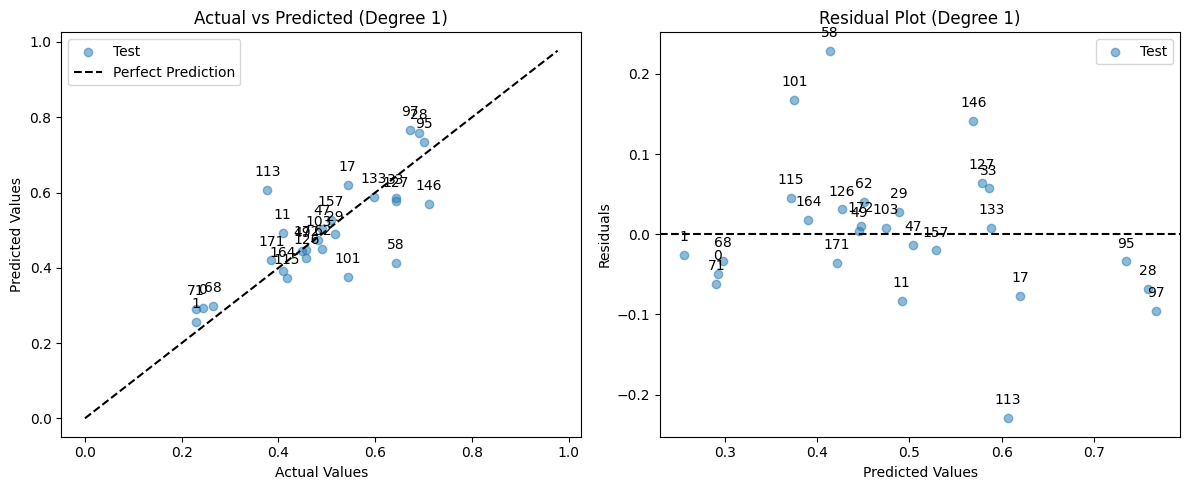

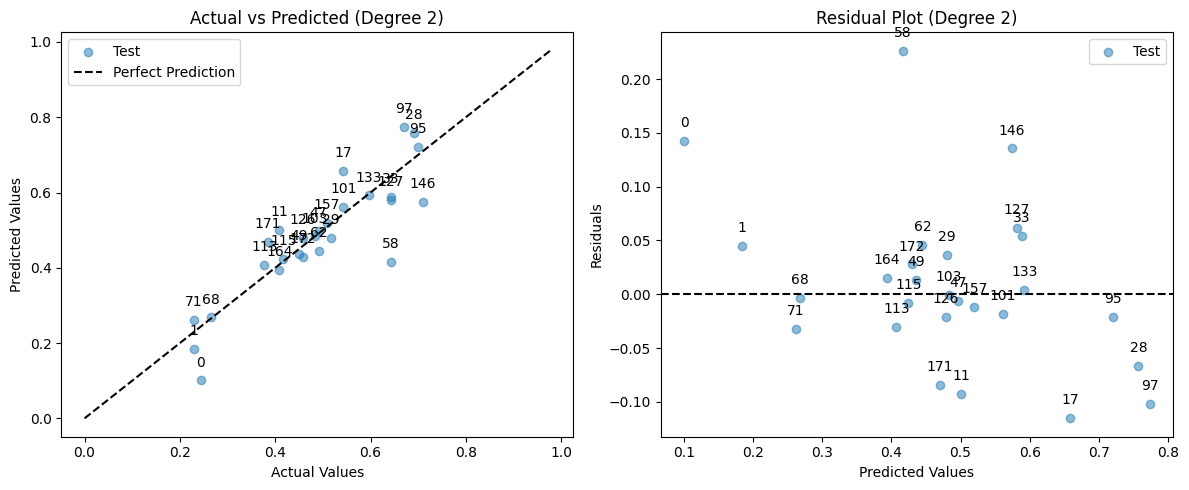

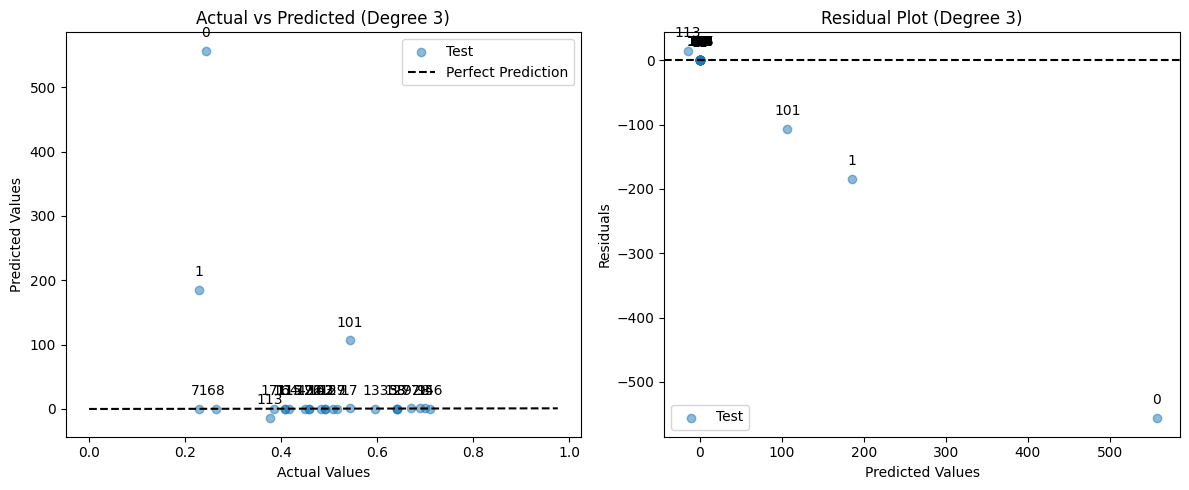

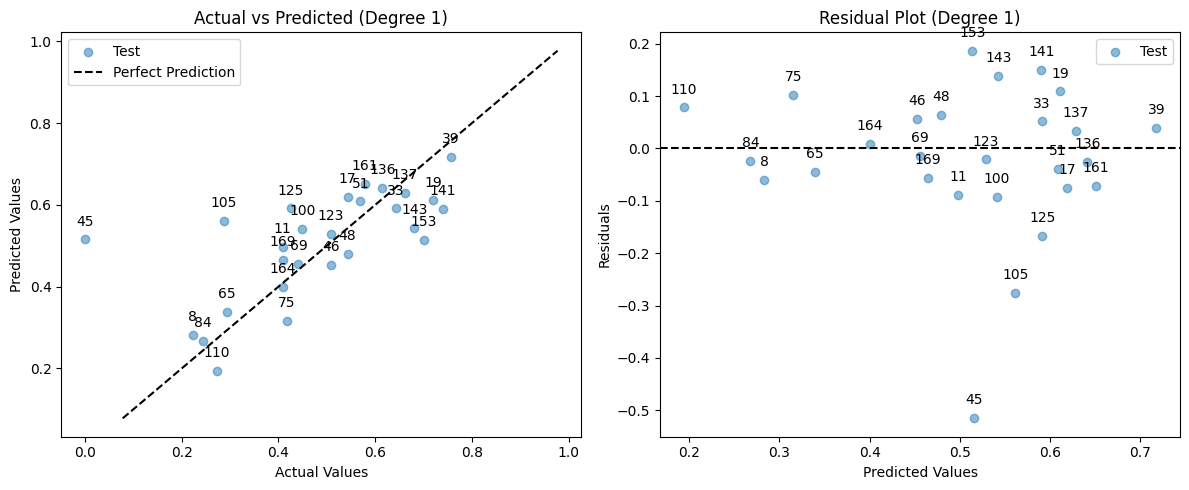

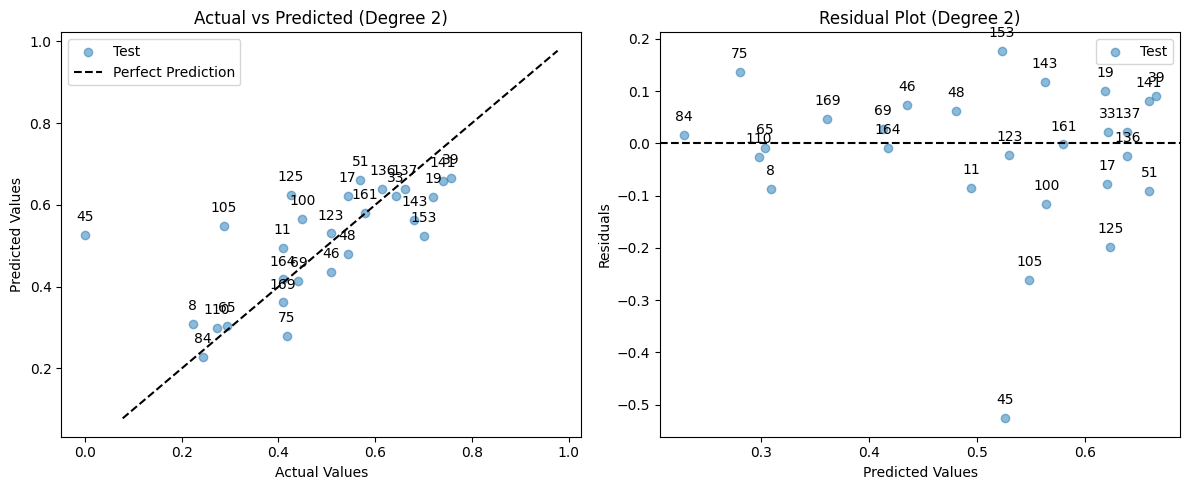

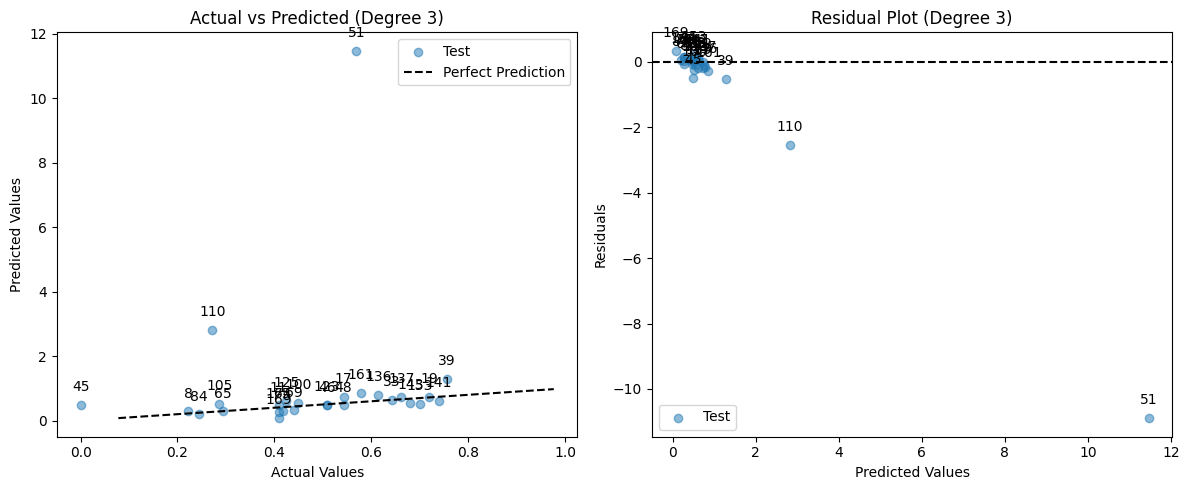

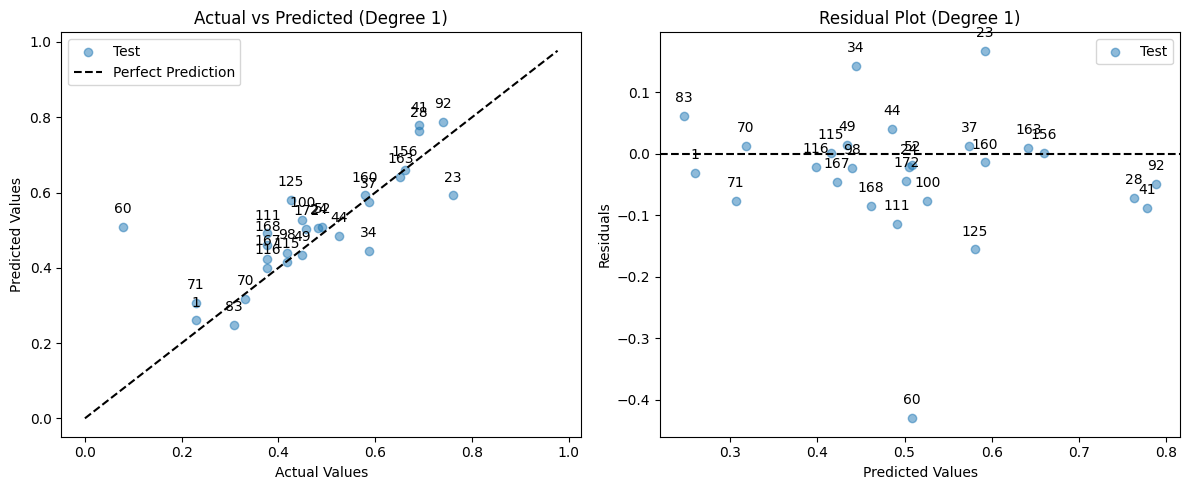

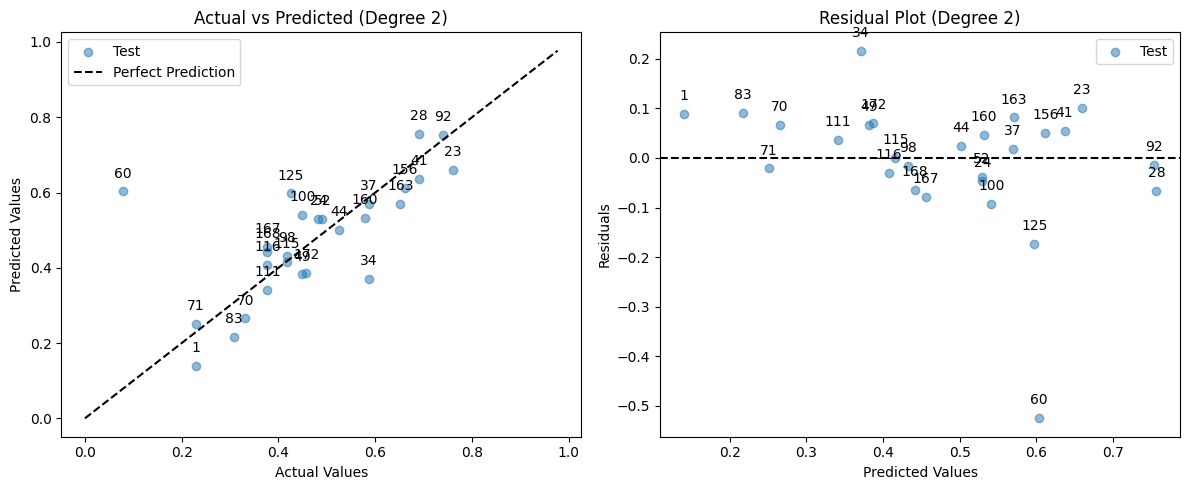

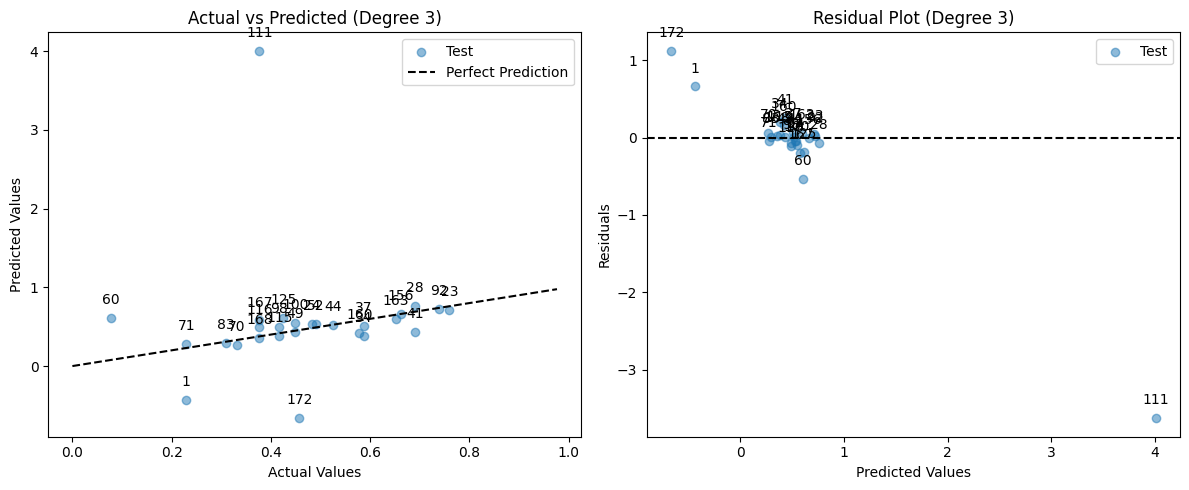


Averaged Model Performance for Different Polynomial Degrees:
        Train R2  Validation R2        Test R2  Cross-Validation R2 Mean  Cross-Validation R2 Std  Train RMSE  Validation RMSE  Test RMSE
Degree                                                                                                                                   
1       0.632280       0.630636       0.545061              5.466551e-01             1.844829e-01    0.117284         0.114428   0.120881
2       0.693526       0.651657       0.541585              3.793825e-01             4.247786e-01    0.107023         0.112973   0.120627
3       0.783424  -10142.823932 -135023.434601             -1.547091e+07             4.374892e+07    0.089799        11.188183  30.571148


In [56]:
df = addfeature_based_multivar_reg

all_results = []
for random_state in random_states:
    results = run_multivariate_analysis(
        df,
        random_state=random_state,
        target_column='tempo_km/h',
        degrees=degrees,
        k=10,
        train_size=0.7,
        val_size=0.15,
        test_size=0.15
    )
    all_results.append(results)

# Average the results
averaged_results = pd.concat(all_results).groupby('Degree').mean()

# Print averaged results table
print("\nAveraged Model Performance for Different Polynomial Degrees:")
print(averaged_results.to_string())

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def train_with_degree(df, target_column, degree=1):
    """Trains a model with specified polynomial degree, hyperparameter tuning, and cross-validation."""
    
    # Prepare data
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)
    
    # Hyperparameter tuning using GridSearchCV
    model = LinearRegression()
    param_grid = {'fit_intercept': [True, False], 
                  'positive': [True, False]}
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train_scaled, y_train)

    # Get best model and its weights
    best_model = grid_search.best_estimator_
    weights = best_model.coef_

    # Create a table of weights
    feature_names = poly.get_feature_names_out(X_train.columns)
    weights_table = pd.DataFrame({'Feature': feature_names, 'Weight': weights})

    # Print the table
    print("\nFinal Model Weights (Degree {}):".format(degree))
    print(weights_table.to_string(index=False))
    
    return best_model  # Return the best model


# Example usage
df = addfeature_based_multivar_reg
degree = 1  # Specify the desired degree
best_model = train_with_degree(df, target_column='tempo_km/h', degree=degree)


Final Model Weights (Degree 1):
        Feature    Weight
        afstand -0.106086
totale_stijging -0.079182
addfeat_asphalt -0.573570
 addfeat_forest -0.682972
  addfeat_dunes -0.156460
   addfeat_temp -0.050166


# End of notebook